In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50V2
import matplotlib.image as mpimg
import cv2
import tensorflow as tf

# Image Classification - CIFAR 100

File was 'unzipped' using 7-zip, then it is unpickled using the below code.

In [3]:
# Code to unpickle is provided by Cifar website.
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
train = unpickle('data/cifar-100-python/train')
test = unpickle('data/cifar-100-python/test')
meta = unpickle('data/cifar-100-python/meta')

# Exploratory Data Analysis


Data is obtained here:
https://www.cs.toronto.edu/~kriz/cifar.html

## Train Set

This data is from the above link.
- 20 superclasses, 5 classes in each superclass
- 100 classes in total
- 500 images in each class (compared to 100 images per class in test set)
- 2500 images in each superclass
- Total training images = 500 x 100 = 50,000 images

File is in a dictionary format, and there are 5 sections:
- image `filenames`
- image `batch labels `
- image `coarse labels` - The superclass to which the image belongs to, and there are 20 superclasses.
- image `fine labels` - The class which the image belongs to. These are sub-classes of superclass, and there are 100 classes in total.
- image `data` - 32 x 32 pixel with 3 RGB values. Came in flattened data 50,000 images x 3,072 values / image

#### Unflattening data

The images came as flattened data with shape of (50000, 3072).  Each image is 32 x 32 or 1,024 pixels.  Each row has 3,072 values, with the first 1,024 representing the `R` value, next 1,024 being the `G` values and the last 1,025 being the `B` values.

To view each image, we need to convert the data to a shape of (32, 32, 3).

In [5]:
Train_flat_data = pd.DataFrame(train[b'data'])

# Check shape 
Train_flat_data.shape

(50000, 3072)

In [6]:
print('BEFORE unflattening data', '\n') 
print('data shape: ', Train_flat_data.shape)

BEFORE unflattening data 

data shape:  (50000, 3072)


In [7]:
# Unflatten data
print('AFTER unflattening data', '\n')
Train_data = np.array(Train_flat_data, dtype=np.uint8).reshape((50000,32,32,3), order='F').transpose(0,2,1,3)
print('data shape: ', Train_data.shape)
print('image shape: ', Train_data[1].shape)

AFTER unflattening data 

data shape:  (50000, 32, 32, 3)
image shape:  (32, 32, 3)


#### Properties

**Filename**

In [8]:
print('filename: ', len(train.get(b'filenames')))

import random
print(random.choice(train.get(b'filenames')))

filename:  50000
b'skyscraper_s_001918.png'


**Batch labels**

In [9]:
print('Number of batch label: ', len(train.get(b'batch_label')))
print(train.get(b'batch_label'))

Number of batch label:  21
b'training batch 1 of 1'


**Fine labels**

In [10]:
print('Number of fine labels: ', len(train.get(b'fine_labels')))
print('Unique values in fine labels (class): ', "\n", np.unique(np.array(train.get(b'fine_labels'))))

Train_fine = pd.DataFrame(train[b'fine_labels']).rename(columns={0: 'fine'})
Train_fine.head()

Number of fine labels:  50000
Unique values in fine labels (class):  
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


fine
0    19
1    29
2     0
3    11
4     1

In [11]:
# check for imbalance

pd.DataFrame(Train_fine.value_counts()).T

fine   0    63   73   72   71   70   69   68   67   66   65   64   62   1   \
0     500  500  500  500  500  500  500  500  500  500  500  500  500  500   

fine   61   60   59   58   57   56   55   54   53   52   74   75   76   77  \
0     500  500  500  500  500  500  500  500  500  500  500  500  500  500   

fine   98   97   96   95   94   93   92   91   90   89   88   87   86   85  \
0     500  500  500  500  500  500  500  500  500  500  500  500  500  500   

fine   84   83   82   81   80   79   78   51   50   49   24   22   21   20  \
0     500  500  500  500  500  500  500  500  500  500  500  500  500  500   

fine   19   18   17   16   15   14   13   12   11   10   9    8    7    6   \
0     500  500  500  500  500  500  500  500  500  500  500  500  500  500   

fine   5    4    3    2    23   25   48   26   47   46   45   44   43   42  \
0     500  500  500  500  500  500  500  500  500  500  500  500  500  500   

fine   41   40   39   38   37   36   35   34   33   32   31   30   29   28  \
0     500  500  500  500  500  500  500  500  500  500  500  500  500  500   

fine   27   99  
0     500  500

**Coarse Labels**

In [12]:
print('Number of coarse labels: ', len(train.get(b'coarse_labels')))
print('Unique values in coarse labels (Superclass): ', "\n", np.unique(np.array(train.get(b'coarse_labels'))))

Train_coarse = pd.DataFrame(train[b'coarse_labels']).rename(columns={0: 'coarse'})
Train_coarse.head()

Number of coarse labels:  50000
Unique values in coarse labels (Superclass):  
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


coarse
0      11
1      15
2       4
3      14
4       1

In [13]:
# check for imbalance

pd.DataFrame(Train_coarse.value_counts()).T

coarse    0     1     18    17    16    15    14    13    12    11    10  \
0       2500  2500  2500  2500  2500  2500  2500  2500  2500  2500  2500   

coarse    9     8     7     6     5     4     3     2     19  
0       2500  2500  2500  2500  2500  2500  2500  2500  2500

## Test Set

Same as training data:
- 20 superclasses
- 100 classes in total
- 100 images in each class (compared to 500 per class in training set)
- 500 images in each superclass
- Total test images = 100 x 100 = 10,000 images

File is in a dictionary format, and there are 5 sections:
- image `filenames`
- image `batch labels `
- image `coarse labels` - The superclass to which the image belongs to, and there are 20 superclasses.
- image `fine labels` - The class which the image belongs to. These are sub-classes of superclass, and there are 100 classes in total.
- image `data` - 32 x 32 pixel with 3 RGB values. Came in flattened data 50,000 images x 3,072 values / image

#### Unflattening data

In [14]:
Test_flat_data = pd.DataFrame(test[b'data'])

In [15]:
print('BEFORE unflattening data', '\n') 
print('data shape: ', Test_flat_data.shape)

BEFORE unflattening data 

data shape:  (10000, 3072)


In [16]:
# Unflatten data
print('AFTER unflattening data', '\n')
Test_data = np.array(Test_flat_data, dtype=np.uint8).reshape((10000,32,32,3), order='F').transpose(0,2,1,3)
print('data shape: ', Test_data.shape)
print('image shape: ', Test_data[1].shape)

AFTER unflattening data 

data shape:  (10000, 32, 32, 3)
image shape:  (32, 32, 3)


#### Properties

**Filename**

In [17]:
print('filename: ', len(test.get(b'filenames')))

filename:  10000


**Batch labels**

In [18]:
print('Number of batch label: ', len(test.get(b'batch_label')))
print(test.get(b'batch_label'))

Number of batch label:  20
b'testing batch 1 of 1'


**Fine labels**

In [19]:
print('Number of fine labels: ', len(test.get(b'fine_labels')))
print('Unique values in fine labels (class): ', "\n", np.unique(np.array(test.get(b'fine_labels'))))

Test_fine = pd.DataFrame(test[b'fine_labels']).rename(columns={0: 'fine'})
Test_fine.head()

Number of fine labels:  10000
Unique values in fine labels (class):  
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


fine
0    49
1    33
2    72
3    51
4    71

In [20]:
# check for imbalance

pd.DataFrame(Test_fine.value_counts()).T

fine   0    63   73   72   71   70   69   68   67   66   65   64   62   1   \
0     100  100  100  100  100  100  100  100  100  100  100  100  100  100   

fine   61   60   59   58   57   56   55   54   53   52   74   75   76   77  \
0     100  100  100  100  100  100  100  100  100  100  100  100  100  100   

fine   98   97   96   95   94   93   92   91   90   89   88   87   86   85  \
0     100  100  100  100  100  100  100  100  100  100  100  100  100  100   

fine   84   83   82   81   80   79   78   51   50   49   24   22   21   20  \
0     100  100  100  100  100  100  100  100  100  100  100  100  100  100   

fine   19   18   17   16   15   14   13   12   11   10   9    8    7    6   \
0     100  100  100  100  100  100  100  100  100  100  100  100  100  100   

fine   5    4    3    2    23   25   48   26   47   46   45   44   43   42  \
0     100  100  100  100  100  100  100  100  100  100  100  100  100  100   

fine   41   40   39   38   37   36   35   34   33   32   31   30   29   28  \
0     100  100  100  100  100  100  100  100  100  100  100  100  100  100   

fine   27   99  
0     100  100

**Coarse Labels**

In [21]:
print('Number of coarse labels: ', len(test.get(b'coarse_labels')))
print('Unique values in coarse labels (Superclass): ', "\n", np.unique(np.array(test.get(b'coarse_labels'))))

Test_coarse = pd.DataFrame(test[b'coarse_labels']).rename(columns={0: 'coarse'})
Test_coarse.head()

Number of coarse labels:  10000
Unique values in coarse labels (Superclass):  
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


coarse
0      10
1      10
2       0
3       4
4      10

In [22]:
# check for imbalance

pd.DataFrame(Test_coarse.value_counts()).T

coarse   0    1    18   17   16   15   14   13   12   11   10   9    8    7   \
0       500  500  500  500  500  500  500  500  500  500  500  500  500  500   

coarse   6    5    4    3    2    19  
0       500  500  500  500  500  500

## Meta data (aka labels)

Meta data file contains the names of each class and superclass. 

In [23]:
Superclass_label = pd.DataFrame(meta[b'coarse_label_names']).rename(columns={0: 'Superclass_label'})
SL = Superclass_label['Superclass_label']
Superclass_label

Superclass_label
0                  b'aquatic_mammals'
1                             b'fish'
2                          b'flowers'
3                  b'food_containers'
4             b'fruit_and_vegetables'
5     b'household_electrical_devices'
6              b'household_furniture'
7                          b'insects'
8                 b'large_carnivores'
9    b'large_man-made_outdoor_things'
10    b'large_natural_outdoor_scenes'
11  b'large_omnivores_and_herbivores'
12                  b'medium_mammals'
13        b'non-insect_invertebrates'
14                          b'people'
15                        b'reptiles'
16                   b'small_mammals'
17                           b'trees'
18                      b'vehicles_1'
19                      b'vehicles_2'

In [24]:
Class_label = pd.DataFrame(meta[b'fine_label_names']).rename(columns={0: 'Class_label'})
CL = Class_label['Class_label']
Class_label.T

0                 1        2        3          4       5   \
Class_label  b'apple'  b'aquarium_fish'  b'baby'  b'bear'  b'beaver'  b'bed'   

                 6          7           8          9        10      11  \
Class_label  b'bee'  b'beetle'  b'bicycle'  b'bottle'  b'bowl'  b'boy'   

                    12      13            14        15      16         17  \
Class_label  b'bridge'  b'bus'  b'butterfly'  b'camel'  b'can'  b'castle'   

                         18         19        20             21        22  \
Class_label  b'caterpillar'  b'cattle'  b'chair'  b'chimpanzee'  b'clock'   

                   23            24        25       26            27      28  \
Class_label  b'cloud'  b'cockroach'  b'couch'  b'crab'  b'crocodile'  b'cup'   

                      29          30           31           32         33  \
Class_label  b'dinosaur'  b'dolphin'  b'elephant'  b'flatfish'  b'forest'   

                 34       35          36        37           38           39  \
Class_label  b'fox'  b'girl'  b'hamster'  b'house'  b'kangaroo'  b'keyboard'   

                  40             41          42       43         44  \
Class_label  b'lamp'  b'lawn_mower'  b'leopard'  b'lion'  b'lizard'   

                     45      46             47             48           49  \
Class_label  b'lobster'  b'man'  b'maple_tree'  b'motorcycle'  b'mountain'   

                   50           51           52         53         54  \
Class_label  b'mouse'  b'mushroom'  b'oak_tree'  b'orange'  b'orchid'   

                   55            56       57               58            59  \
Class_label  b'otter'  b'palm_tree'  b'pear'  b'pickup_truck'  b'pine_tree'   

                   60        61        62            63         64         65  \
Class_label  b'plain'  b'plate'  b'poppy'  b'porcupine'  b'possum'  b'rabbit'   

                     66      67       68         69       70      71       72  \
Class_label  b'raccoon'  b'ray'  b'road'  b'rocket'  b'rose'  b'sea'  b'seal'   

                   73        74        75             76        77        78  \
Class_label  b'shark'  b'shrew'  b'skunk'  b'skyscraper'  b'snail'  b'snake'   

                    79           80            81            82  \
Class_label  b'spider'  b'squirrel'  b'streetcar'  b'sunflower'   

                          83        84       85            86             87  \
Class_label  b'sweet_pepper'  b'table'  b'tank'  b'telephone'  b'television'   

                   88          89        90        91        92         93  \
Class_label  b'tiger'  b'tractor'  b'train'  b'trout'  b'tulip'  b'turtle'   

                      94        95              96       97        98       99  
Class_label  b'wardrobe'  b'whale'  b'willow_tree'  b'wolf'  b'woman'  b'worm'

**Type, Shape and Keys**

In [25]:
print('Type: ', type(train))
print('Type: ', type(Train_data))
print('Shape: ', Train_data.shape)
print('Keys: ', train.keys())

Type:  <class 'dict'>
Type:  <class 'numpy.ndarray'>
Shape:  (50000, 32, 32, 3)
Keys:  dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


In [26]:
print('Type: ', type(test))
print('Type: ', type(Test_data))
print('Shape: ', Test_data.shape)
print('Keys: ', test.keys())

Type:  <class 'dict'>
Type:  <class 'numpy.ndarray'>
Shape:  (10000, 32, 32, 3)
Keys:  dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


## Duplicates & Null

The images came as flattened data with shape of (50000, 3072).  Each image is 32 x 32, therefore, the total is 1,024 pixels.  Each row has 3,072 values, with the first 1,024 representing the `R` value, next 1,024 being the `G` values and the last 1,025 being the `B` values.

To view each image, we need to convert the data to a shape of (32, 32, 3).

In [27]:
# Check for duplicates
Train_flat_data.duplicated().sum()

14

<ipython-input-28-76331bbea16f>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(3,3))


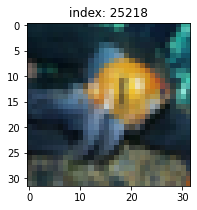

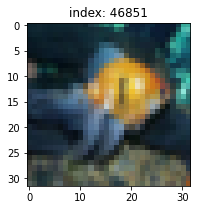

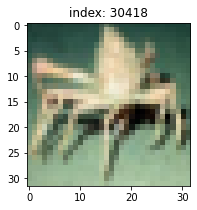

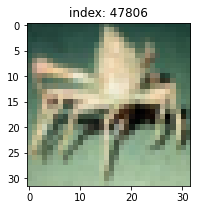

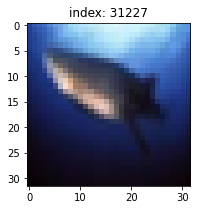

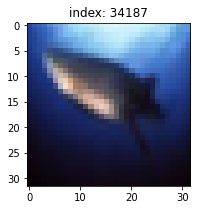

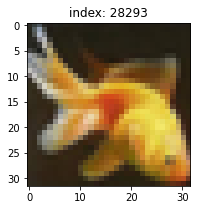

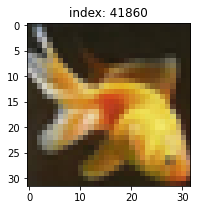

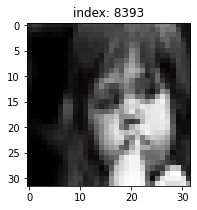

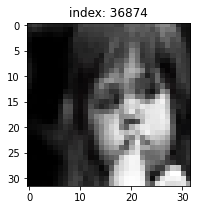

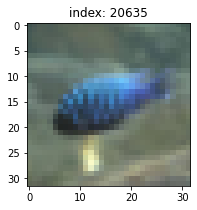

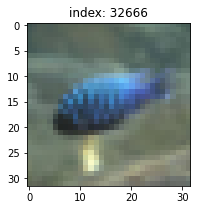

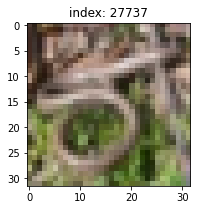

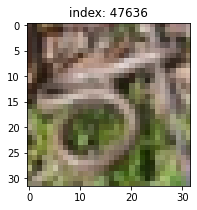

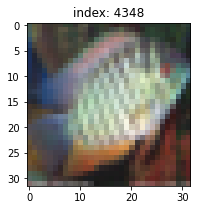

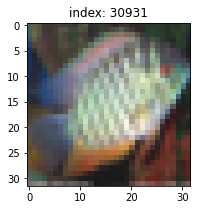

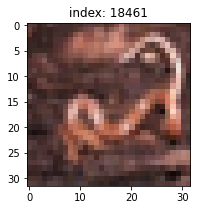

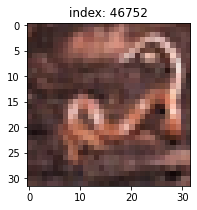

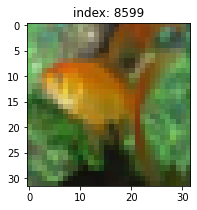

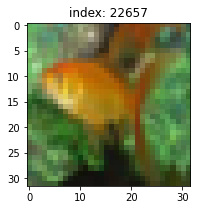

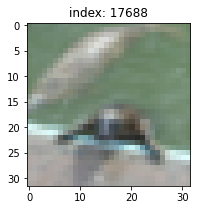

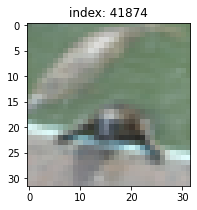

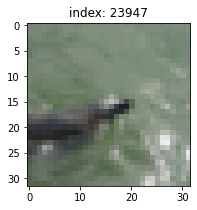

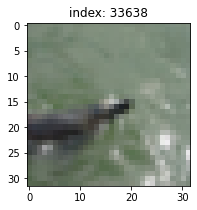

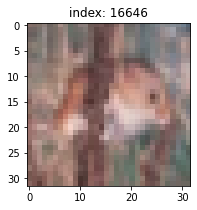

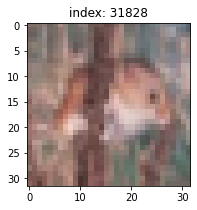

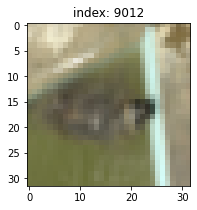

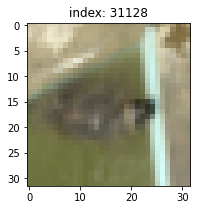

In [28]:
# Look at what duplicated images look like

duplicated_image_index = Train_flat_data[Train_flat_data.duplicated(keep=False)].sort_values(by=[0,1,2,3,4]).index

for i in duplicated_image_index:
    images = train[b'data'].reshape((50000,32,32,3), order='F').transpose(0,2,1,3) 
    plt.figure(figsize=(3,3))
    plt.imshow(images[i])
    plt.title(f'index: {i}')


There are duplicated images, but not a lot relative to the size of the dataset. We will keep them as this will keep all the classes balance.

In [29]:
# Check for null values

Train_flat_data.isna().sum().sum()

0

## Grayscaled

It would be interesting to see if the CNN models will give a higher or lower accuracy score in predicting grayscale images vs colour images. The below codes are to transform images into grayscale.

In [30]:
def grayscale(color_dataset):
    '''
    This function converts all colour images in the dataset to grayscale.
    
    INPUT: flatten image dataset with a shape of (num_of_samples, height, width, RGB)
    OUTPUT: flatten image dataset with a shape of (num_of_samples, height, width) 
    
    '''
    # Input can be dataset of any shape
    shape = color_dataset.shape
    
    # Create a new variable to store images converted into grayscale
    grayscale_dataset = np.zeros((shape[0], int(shape[1]/3)))
    
    # loop through each line or image to convert RGB into luminosity 
    for idx in range(shape[0]):
        if idx % 1000 == 0:
            print(idx, end="\r")
        color_image = color_dataset.iloc[idx,:]
        new_image = np.zeros(1024)
        
        # Average formula from https://www.johndcook.com/blog/2009/08/24/algorithms-convert-color-grayscale/
        for i in range(1024):
            R = color_image[i]*0.21  
            G = color_image[i+1024]*0.72  
            B = color_image[i+2048]*0.07   

            new_image[i] = R+G+B
            
        
        # Append new image to grayscale dataset
        grayscale_dataset[idx] = new_image

    return grayscale_dataset

#### Convert Train Set to Grayscale

In [31]:
# Convert color images to grayscale
Train_flat_data_gray = grayscale(Train_flat_data)

In [32]:
# Check shape before unflatten
print('BEFORE unflattening data', '\n') 
print('data shape: ', Train_flat_data_gray.shape, '\n')

# Unflatten data
print('AFTER unflattening data', '\n')
Train_data_gray = np.array(Train_flat_data_gray, dtype=np.uint8).reshape((50000,32,32,1))
print('data shape: ', Train_data_gray.shape)
print('image shape: ', Train_data_gray[1].shape)

BEFORE unflattening data 

data shape:  (50000, 1024) 

AFTER unflattening data 

data shape:  (50000, 32, 32, 1)
image shape:  (32, 32, 1)


superclass:  0
b'aquatic_mammals'


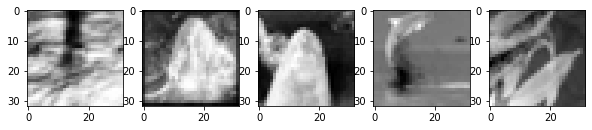

superclass:  1
b'fish'


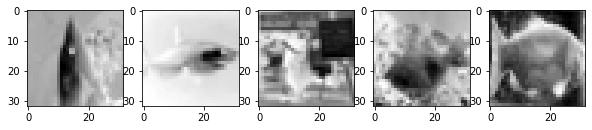

superclass:  2
b'flowers'


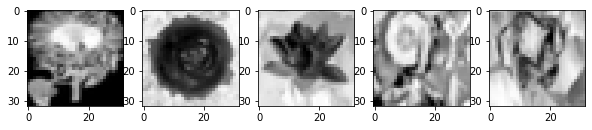

superclass:  3
b'food_containers'


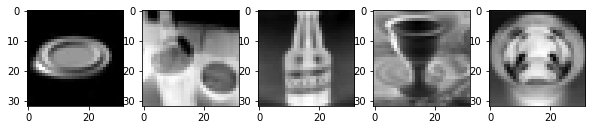

superclass:  4
b'fruit_and_vegetables'


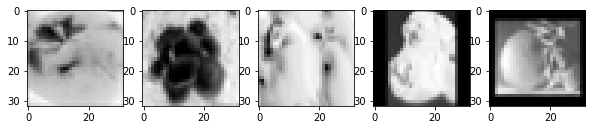

superclass:  5
b'household_electrical_devices'


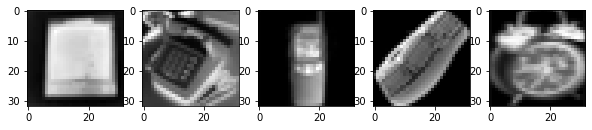

superclass:  6
b'household_furniture'


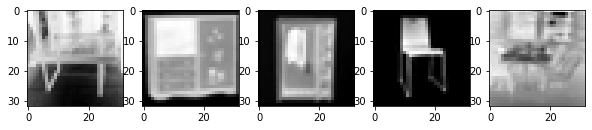

superclass:  7
b'insects'


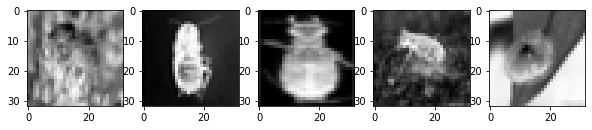

superclass:  8
b'large_carnivores'


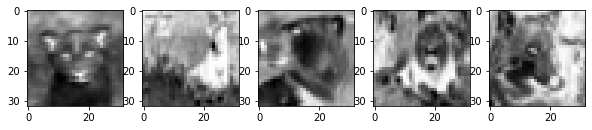

superclass:  9
b'large_man-made_outdoor_things'


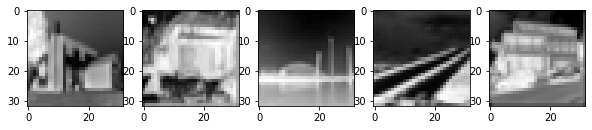

superclass:  10
b'large_natural_outdoor_scenes'


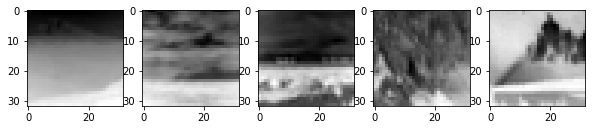

superclass:  11
b'large_omnivores_and_herbivores'


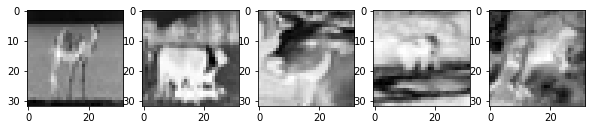

superclass:  12
b'medium_mammals'


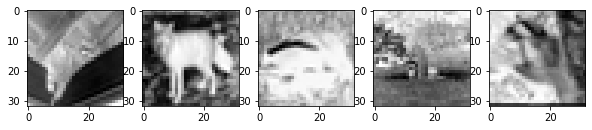

superclass:  13
b'non-insect_invertebrates'


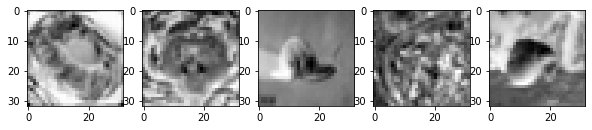

superclass:  14
b'people'


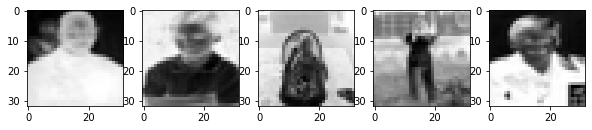

superclass:  15
b'reptiles'


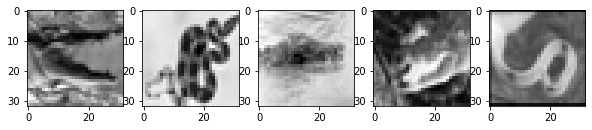

superclass:  16
b'small_mammals'


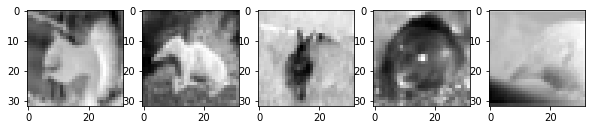

superclass:  17
b'trees'


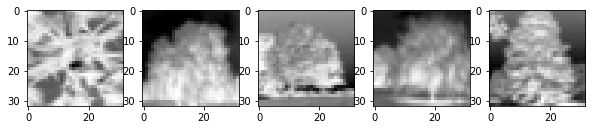

superclass:  18
b'vehicles_1'


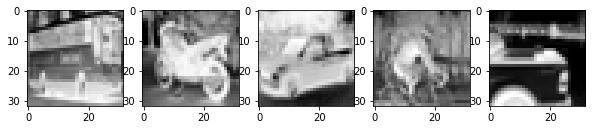

superclass:  19
b'vehicles_2'


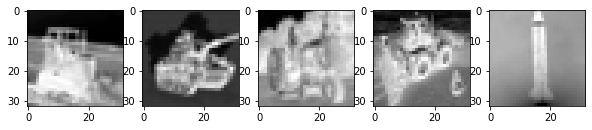

In [33]:
# Print 5 random images from each superclass

Superclass_index = sorted(Train_coarse['coarse'].unique())

for s in Superclass_index:
    #create subplots
    plt.subplots(1,5, figsize=(10,10))
    print('superclass: ', s)
    print(Superclass_label.iloc[s]['Superclass_label'])
    
    for i in range(0,5):
        # find a random image of this superclass
        index = random.choice(Train_coarse.index[Train_coarse['coarse'] == s])

        # plot image
        image = Train_data_gray[index]
        plt.subplot(1,5,i+1) 
        plt.imshow(image, cmap='gray_r')
        
    plt.show()


Images are a lot more difficult to decipher when it turned into grayscale. 

#### Convert Test Set to Grayscale

In [34]:
# Convert color images to grayscale
Test_flat_data_gray = grayscale(Test_flat_data)

In [35]:
# Check shape before unflatten
print('BEFORE unflattening data', '\n') 
print('data shape: ', Test_flat_data_gray.shape, '\n')

# Unflatten data
print('AFTER unflattening data', '\n')
Test_data_gray = np.array(Test_flat_data_gray, dtype=np.uint8).reshape((10000,32,32,1))
print('data shape: ', Test_data_gray.shape)
print('image shape: ', Test_data_gray[1].shape)

BEFORE unflattening data 

data shape:  (10000, 1024) 

AFTER unflattening data 

data shape:  (10000, 32, 32, 1)
image shape:  (32, 32, 1)


superclass:  0
b'aquatic_mammals'


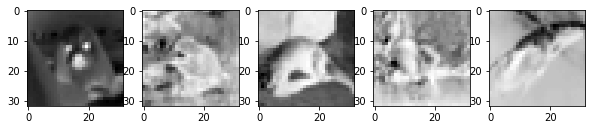

superclass:  1
b'fish'


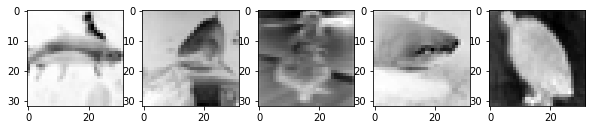

superclass:  2
b'flowers'


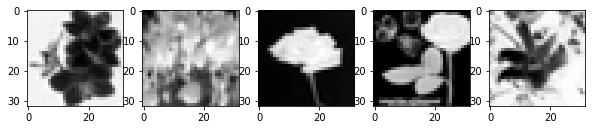

superclass:  3
b'food_containers'


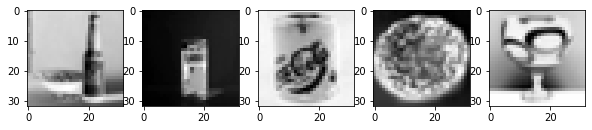

superclass:  4
b'fruit_and_vegetables'


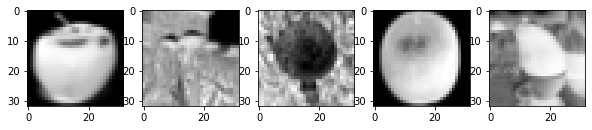

superclass:  5
b'household_electrical_devices'


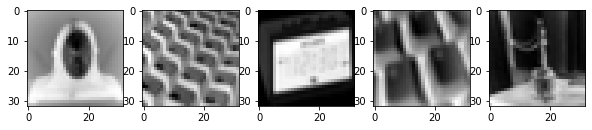

superclass:  6
b'household_furniture'


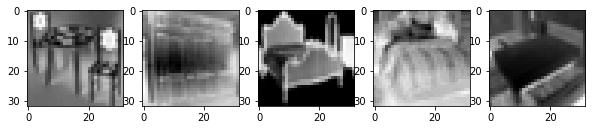

superclass:  7
b'insects'


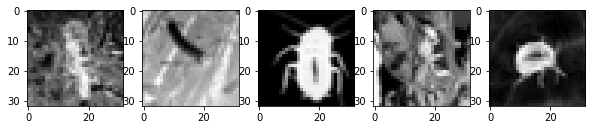

superclass:  8
b'large_carnivores'


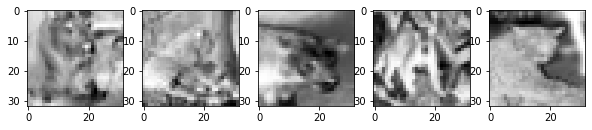

superclass:  9
b'large_man-made_outdoor_things'


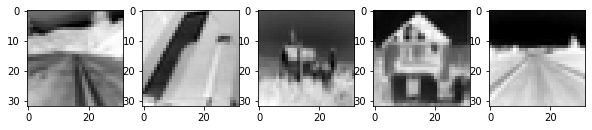

superclass:  10
b'large_natural_outdoor_scenes'


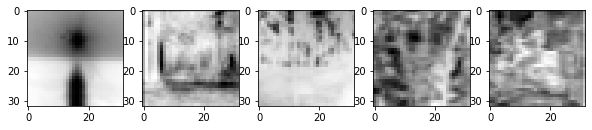

superclass:  11
b'large_omnivores_and_herbivores'


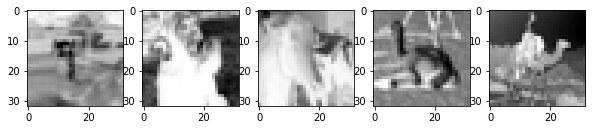

superclass:  12
b'medium_mammals'


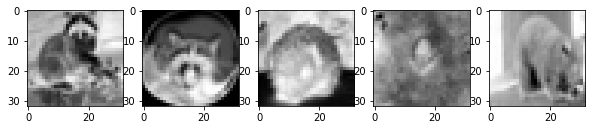

superclass:  13
b'non-insect_invertebrates'


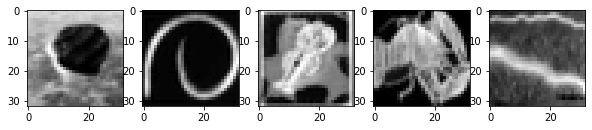

superclass:  14
b'people'


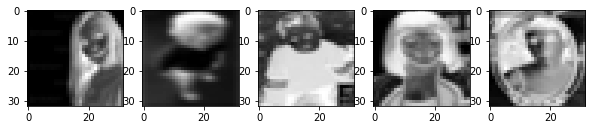

superclass:  15
b'reptiles'


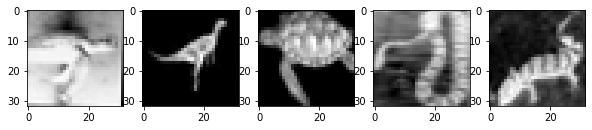

superclass:  16
b'small_mammals'


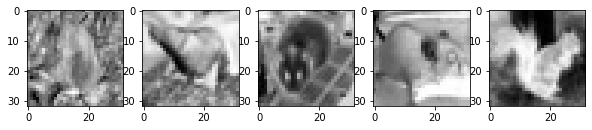

superclass:  17
b'trees'


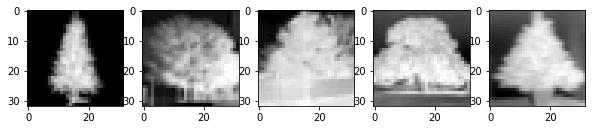

superclass:  18
b'vehicles_1'


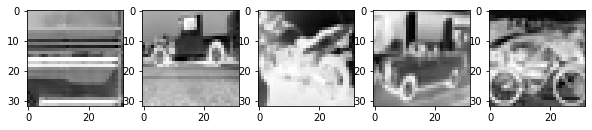

superclass:  19
b'vehicles_2'


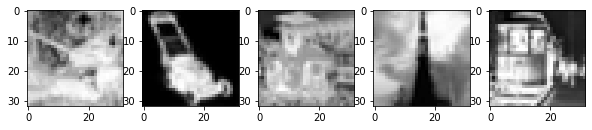

In [36]:
# Print 5 random images from each superclass

Superclass_index = sorted(Test_coarse['coarse'].unique())

for s in Superclass_index:
    #create subplots
    plt.subplots(1,5, figsize=(10,10))
    print('superclass: ', s)
    print(Superclass_label.iloc[s]['Superclass_label'])
    
    for i in range(0,5):
        # find a random image of this superclass
        index = random.choice(Test_coarse.index[Test_coarse['coarse'] == s])

        # plot image
        image = Test_data_gray[index]
        plt.subplot(1,5,i+1) 
        plt.imshow(image, cmap='gray_r')
        
    plt.show()


## Random images from each superclass

Look at random images to get a sense what each superclass look like.

superclass:  0
b'aquatic_mammals'


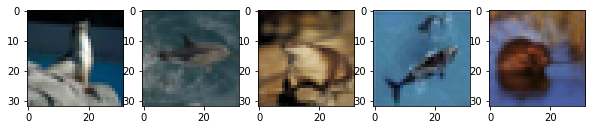

superclass:  1
b'fish'


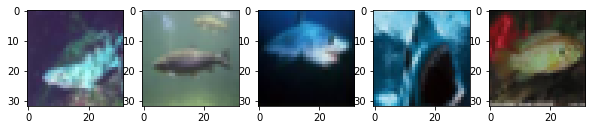

superclass:  2
b'flowers'


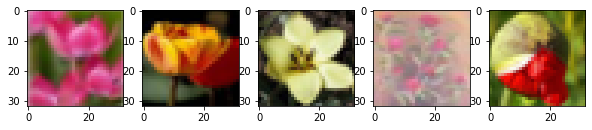

superclass:  3
b'food_containers'


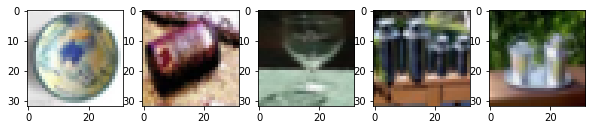

superclass:  4
b'fruit_and_vegetables'


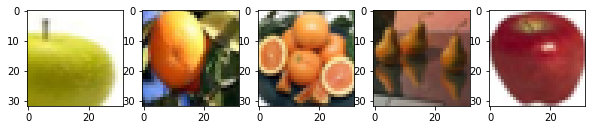

superclass:  5
b'household_electrical_devices'


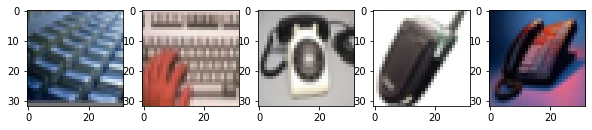

superclass:  6
b'household_furniture'


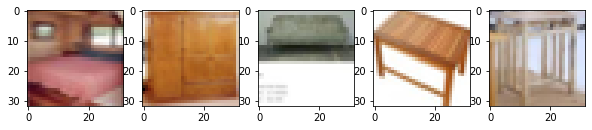

superclass:  7
b'insects'


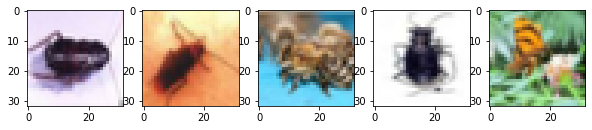

superclass:  8
b'large_carnivores'


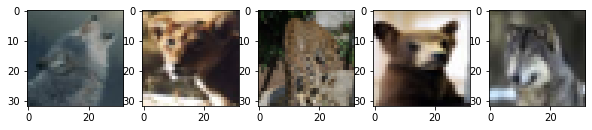

superclass:  9
b'large_man-made_outdoor_things'


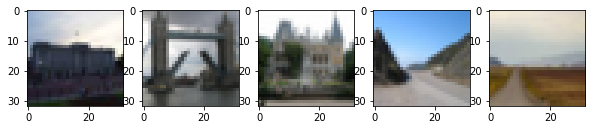

superclass:  10
b'large_natural_outdoor_scenes'


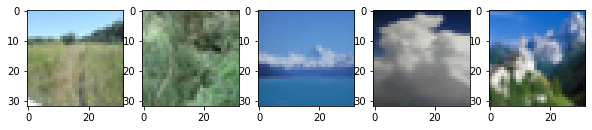

superclass:  11
b'large_omnivores_and_herbivores'


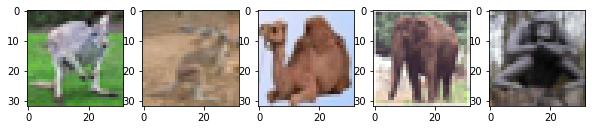

superclass:  12
b'medium_mammals'


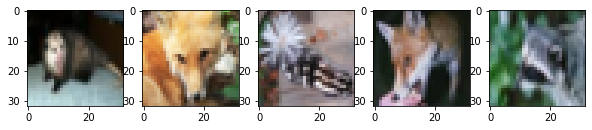

superclass:  13
b'non-insect_invertebrates'


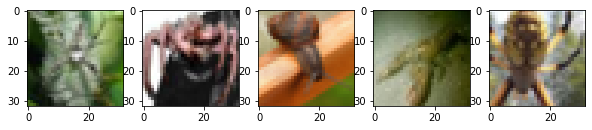

superclass:  14
b'people'


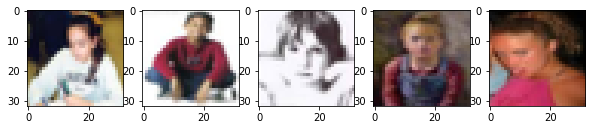

superclass:  15
b'reptiles'


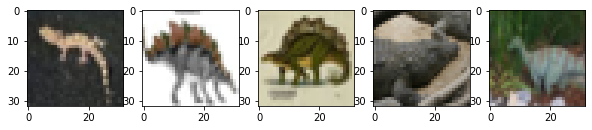

superclass:  16
b'small_mammals'


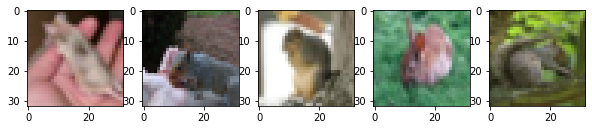

superclass:  17
b'trees'


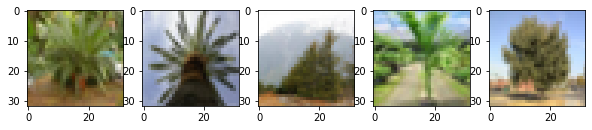

superclass:  18
b'vehicles_1'


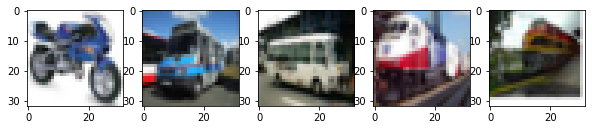

superclass:  19
b'vehicles_2'


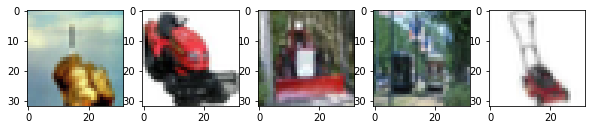

In [37]:
# Print 5 random images from each superclass

Superclass_index = sorted(Train_coarse['coarse'].unique())

for s in Superclass_index:
    #create subplots
    plt.subplots(1,5, figsize=(10,10))
    print('superclass: ', s)
    print(Superclass_label.iloc[s]['Superclass_label'])
    
    for i in range(0,5):
        # find a random image of this superclass
        index = random.choice(Train_coarse.index[Train_coarse['coarse'] == s])

        # plot image
        image = Train_data[index]
        plt.subplot(1,5,i+1) 
        plt.imshow(image)
        
    plt.show()


There are not a lot of resemblances in the class `fruits and vegetables`, particularly mushrooms are grouped there.

## Average of RGB for each superclass

Look at the 'average' image in each superclass to get a sense of how different and similar images are within each class. Perhaps, we can get a sense of what superclasses would be easy to predict or be confused.

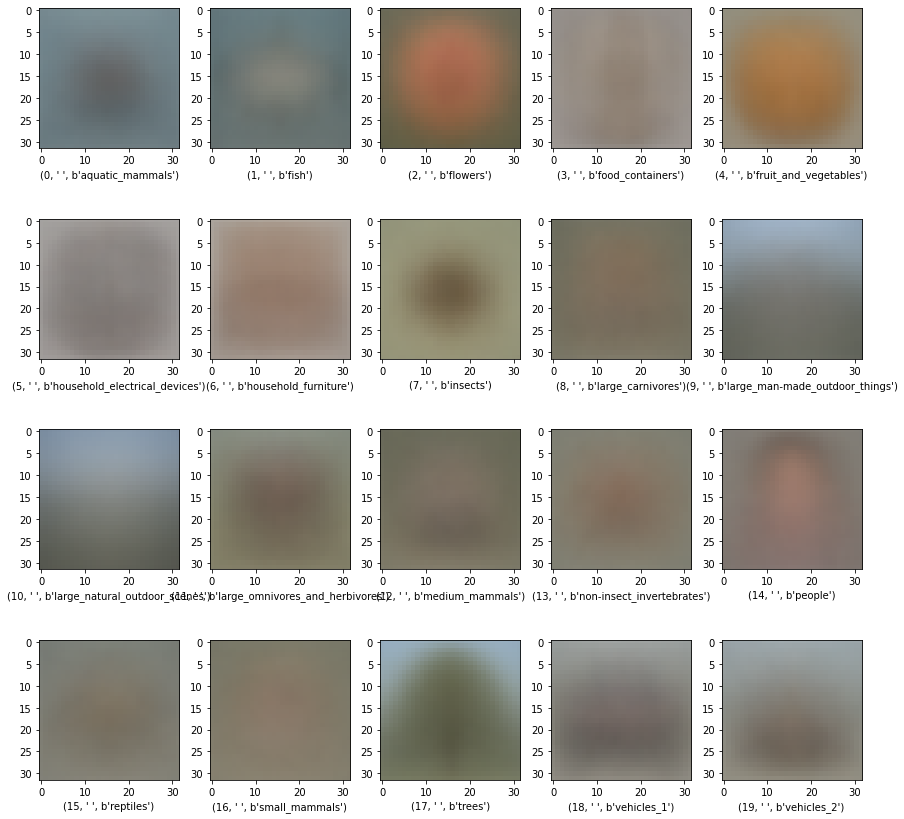

In [212]:
# Create list of Superclass index
Superclass_index = sorted(Train_coarse['coarse'].unique())
plt.subplots(4,5, figsize=(12,12))

for s in Superclass_index:
    # Find all the rows in data table that pertains to each superclass
    index_list = Train_coarse.index[Train_coarse['coarse'] == s]
    
    # Take the average all of those rows 
    averageRGB = np.mean(Train_data[index_list], axis=0, dtype=np.int64) # this will give [32,3,3] shape
    
    # print name of superclass
    title = s, ' ', Superclass_label.iloc[s]['Superclass_label']
    
    # plot image
    plt.subplot(4,5,s+1)
    plt.imshow(averageRGB)
    plt.xlabel(title)

plt.tight_layout()
plt.show()
    

Of all superclasses, `trees` and `people` might be the most distinct. I expect the CNN models can easily recognize these images correctly. `Flower` superclass is also very clear but I wonder if this class will be confused as `fruits and vegetables` because the center of them are both orange.

## Average of RGB for 25 random classes

Here we will also visualize the average image of the classes.

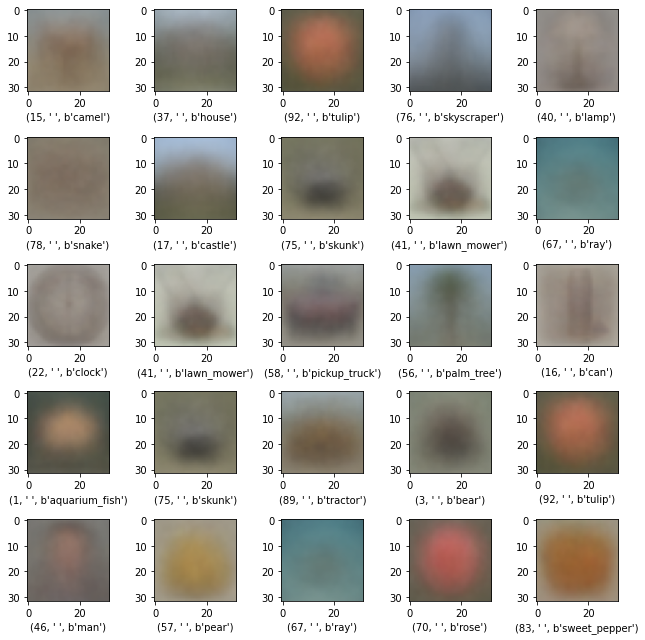

In [211]:
# Create list of Superclass index
Class_index = sorted(Train_fine['fine'].unique())
plt.subplots(5,5, figsize=(9,9))

for i in range(25):
    # take a random number from class index
    c = random.choice(Class_index)
    
    # Find all the rows in data table that pertains to each superclass
    index_list = Train_fine.index[Train_fine['fine'] == c]
    
    # Take the average all of those rows 
    averageRGB = np.mean(Train_data[index_list], axis=0, dtype=np.int64) # this will give [32,3,3] shape
    
    # print name of superclass
    title = c, ' ', Class_label.iloc[c]['Class_label']
    
    # plot image
    plt.subplot(5,5,i+1)
    plt.imshow(averageRGB)
    plt.xlabel(title)

plt.tight_layout()
plt.show()
    

The average images are definitely more clear than the ones in superclasses. However, some classes still look similar to others, for example, `boy` and `man` are quite similar. 

# Classification Models - Superclass

The goal is train a CNN model that can predict the augmented image of the 100 classes. To begin, we will train some CNN models on non-augmented images by superclass to make it more manageable in interpreting results and optimizing parameters of the CNN models. Once that worked out, I will apply the best models to train the augmented 100 by classes.

## Color - Superclass (Non-Augmented)

### Basic Models - Logistic Regression

First of all, we will try out the basic model and see how the accuracy scores are.

In [70]:
# Set our X_train, y_train and X_test, y_test

X_train_flat = Train_flat_data
y_train = np.array(train[b'coarse_labels']) #set coarse/superclass as our classification target

X_test_flat = Test_flat_data
y_test = np.array(test[b'coarse_labels'])

In [71]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=1, n_jobs=-1)
LR.fit(X_train_flat, y_train)
print('Train score: ', LR.score(X_train_flat, y_train))
print('Test score: ', LR.score(X_test_flat, y_test))

Train score:  0.29046
Test score:  0.2597


The accuracy score on test set is 26%, which is probably our baseline accuracy score. 

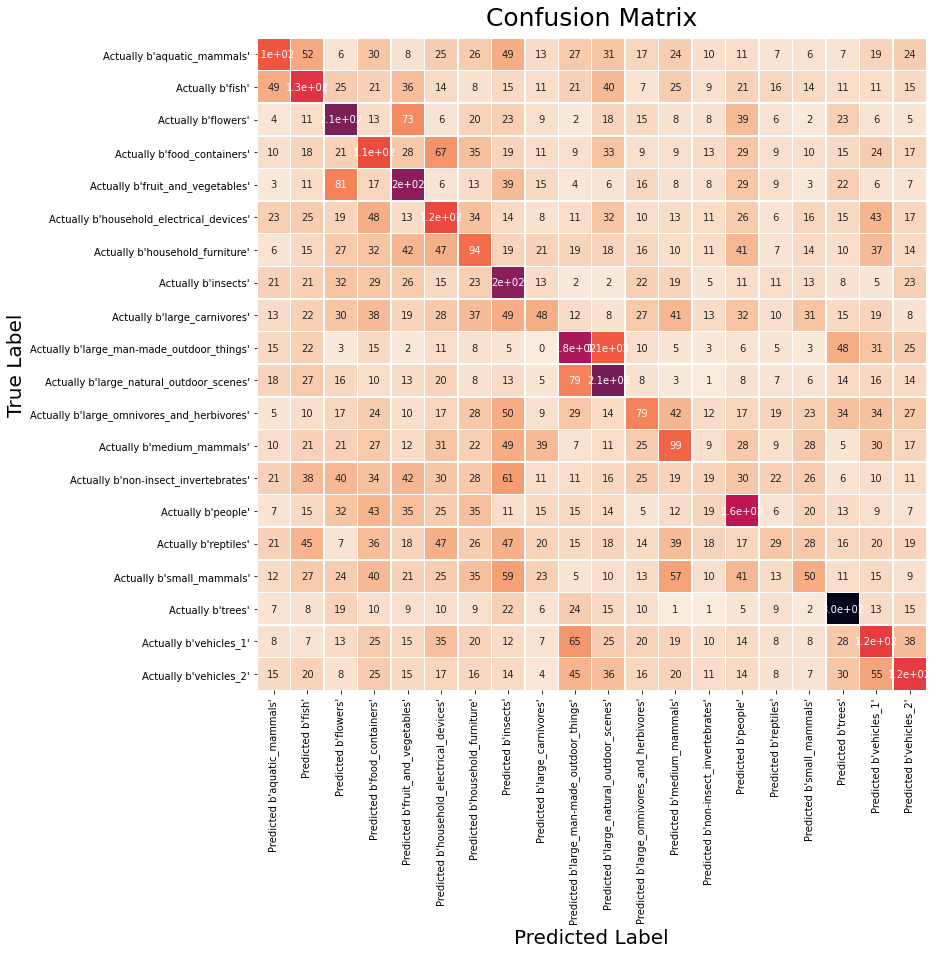

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Make classifications based on the test features, and assign the classifications to a variable
LR_y_pred = LR.predict(X_test_flat)

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, LR_y_pred))
confusion_df.index = [f'Actually {i}' for i in Superclass_label['Superclass_label']]
confusion_df.columns = [f'Predicted {i}' for i in Superclass_label['Superclass_label']]


plt.figure(figsize = (12,12))
sns.heatmap(confusion_df,
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=0.5
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

The accuracy on prediction in each superclass is terrible!

### CNN Models

#### Set up train and test sets

In [38]:
# Set our X_train, y_train and X_test, y_test

X_train = Train_data
y_train = Train_coarse #set coarse/superclass as our classification target

X_test = Test_data
y_test = Test_coarse

Before scaling, check what is the range of values in the data.

In [39]:
print(f'X_train range: {X_train.min()}-{X_train.max()}')
print(f'X_train range: {X_test.min()}-{X_test.max()}')

X_train range: 0-255
X_train range: 0-255


In [40]:
# Scale the X values to between 0 to 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(f'X_train range: {X_train.min()}-{X_train.max()}')

X_train range: 0.0-1.0


Let's double check the shape of our data before starting any CNN models.

In [41]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

To streamline the CNN models and minimize the amount of codes, I built a few functions before for calculating the test loss and accuracy, plotting the accuracy/loss and running the confusion matrix. In each CNN model, we will also establish a early stop function to avoid overfitting. 

In [42]:
    #=========================================================================================
    # ACCURACY ON TEST SCORE
    #=========================================================================================
    
    def test_loss_score(model):

        # Evaluate the model's performance on the test data
        score = model.evaluate(X_test, y_test, verbose=3)

        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n', '\n')
    
    #=========================================================================================
     # TRAINING/VALIDATION ACCURACY AND LOSS
    #=========================================================================================
    
    def accuracy_loss_plots(model):
        # Set up two subplots
        plt.subplots(1, 2, figsize=(18, 6))

        # Plot accuracies
        plt.subplot(1, 2, 1)
        plt.plot(model.history['accuracy'], label='Train', marker='.')
        plt.plot(model.history['val_accuracy'], label='Validation', marker='.')
        plt.title('Accuracies Across Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot losses
        plt.subplot(1, 2, 2)
        plt.plot(model.history['loss'], label='Train', marker='.')
        plt.plot(model.history['val_loss'], label='Validation', marker='.')
        plt.title('Losses Across Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # This ensures the subplots do not overlap
        plt.tight_layout()

        # Show the subplots
        plt.show()

    #=========================================================================================
    # CONFUSION MATRIX
    #=========================================================================================
   
    from sklearn.metrics import confusion_matrix
    def confusion(model):
        # Calculate the predicted labels for each test image.
        predict_probas = model.predict(X_test)
        y_predict = np.argmax(predict_probas, axis=1)

        # Create the confusion matrix using sklearn 
        conf_mat = confusion_matrix(y_test, y_predict)

        # Since we have many images, it is helpful to show our 
        # results as fractions of the total number of images 
        # for each class.
        normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

        normalized_conf_mat = pd.DataFrame(normalized_conf_mat, columns=SL).set_index(SL)

        plt.figure(figsize = (12,12))
        sns.heatmap(normalized_conf_mat,
                    annot=True,
                    cbar=False,
                    cmap="rocket_r",
                    linewidths=1
                   )
        plt.title('Confusion Matrix',size = 25,y=1.01)
        plt.xlabel("Predicted Label", size = 20)
        plt.ylabel("True Label", size = 20)
        plt.show()
 

# Define early stop
ES = EarlyStopping(monitor='val_loss', patience=5, mode='auto', min_delta=0.001, verbose=1)


##### CNN 1 - Model 1

We will try out a few CNN models using parameters seen in class. Based on the performance of each model, the next model we will try to modify certain parameters (ex. dropout rate, # of filters and layers) as we see fit.

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_84 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_85 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 4, 4, 256)       

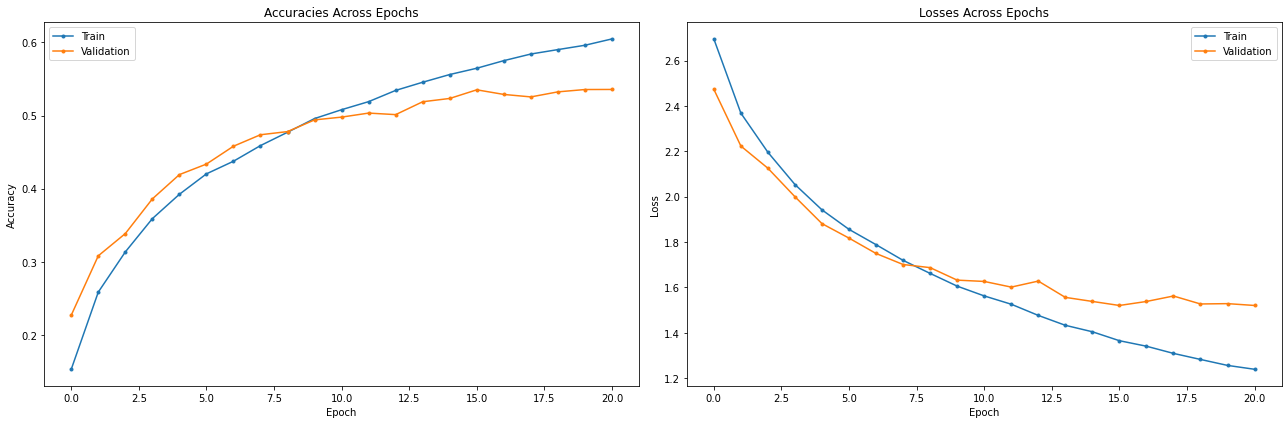

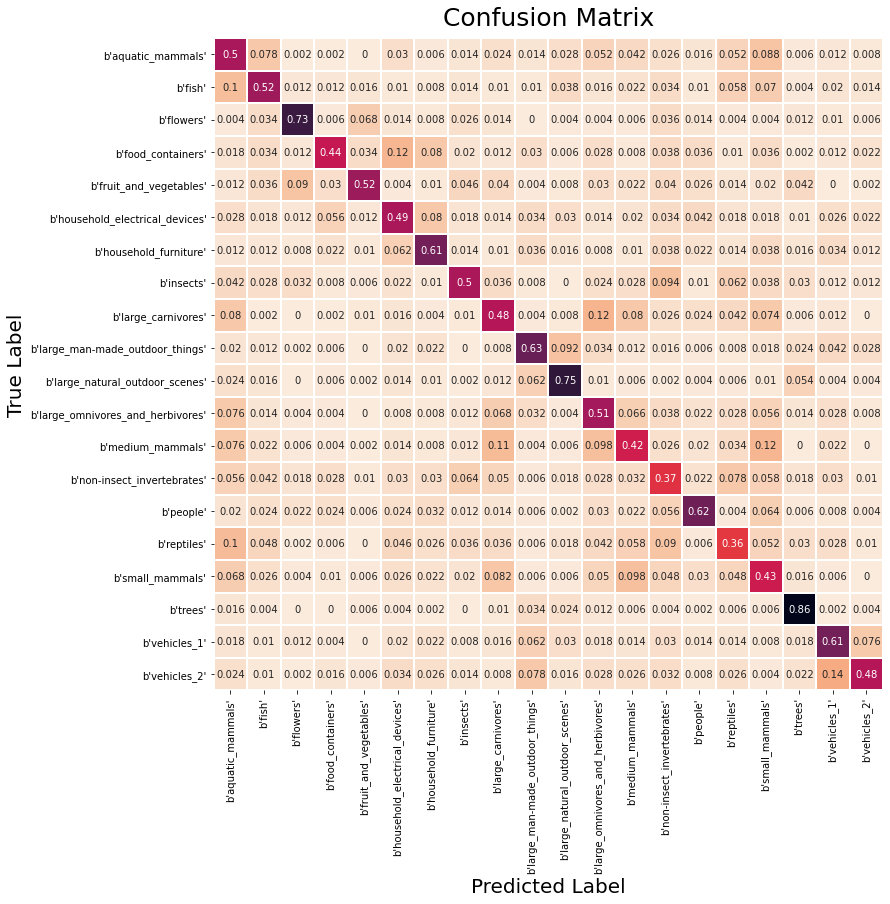

In [375]:
CNN_model = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (32,32,3)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(256, kernel_size=(3, 3), activation = 'relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.2))

# Flatten the output of our convolutional layers
CNN_model.add(Flatten())

# Add dense layers
CNN_model.add(Dense(256, activation= 'relu'))
CNN_model.add(Dense(64, activation= 'relu'))
CNN_model.add(Dense(32, activation= 'relu'))
CNN_model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Print out a summary of the network
CNN_model.summary()

# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN_model.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
CNN1 = CNN_model.fit(X_train, y_train,
              batch_size = 128,
              epochs = 50,
              verbose = 1,
              validation_split = 0.2,
              callbacks= ES)



test_loss_score(CNN_model)
accuracy_loss_plots(CNN1)
confusion(CNN_model)
CNN_model.save('CNNmodels/CNN_model.h5')

The accuracy on test set is 54%, which is higher than our logistic regression! The interesting thing here is that the confusion matrix shows prediction of certain superclasses (ex. trees, people, large natural outdoor scene) are well above 54%! Prediction on certain superclasses are very poor, which is probably why the average score on test set is only 54%! 

Some particular highlights of `confusions` are:
- Aquatic Mammals are often confused as fish, vice versa.
- Small Mammals, Medium Mammals and Large Carnivores are often confused with each other.
- Reptiles and Non-insect invertebrates are often confused with each other.
- Vehicle 1 and Vehicle 2 are often confused with each other.

##### CNN 1 - Model 2

Modle 1 started to overfit starting on the 10th epoch. I wonder if accuracy would improve while not overfitting by changing the dropout rate at each layer. The above model has a dropout rate of 0.2 in each layer. Here we will try 0.1, 0.2, 0.4 in each corresponding layer.

In [ ]:
CNN_model2 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model2.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (32,32,3)))
CNN_model2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model2.add(Dropout(0.1))

CNN_model2.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu'))
CNN_model2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model2.add(Dropout(0.2))

CNN_model2.add(Conv2D(256, kernel_size=(3, 3), activation = 'relu'))
CNN_model2.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model2.add(Dropout(0.4))

# Flatten the output of our convolutional layers
CNN_model2.add(Flatten())

# Add dense layers
CNN_model2.add(Dense(256, activation= 'relu'))
CNN_model2.add(Dense(64, activation= 'relu'))
CNN_model2.add(Dense(32, activation= 'relu'))
CNN_model2.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Print out a summary of the network
CNN_model2.summary()

# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN_model2.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
CNN2 = CNN_model2.fit(X_train, y_train,
              batch_size = 128,
              epochs = 50,
              verbose = 1,
              validation_split = 0.2,
              callbacks =ES)



test_loss_score(CNN_model2)
accuracy_loss_plots(CNN2)
confusion(CNN_model2)

# save model
CNN_model2.save('CNNmodels/CNN_model2.h5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 256)        

Model 2 overfit a bit later than the Model 1 after changing the dropout rate, but accuracy did not improve much. 

##### CNN 1 - Model 3

In this model, we will increase the number of filters in each layer, and maybe the model can learn more from the images and that could improve accuracy. Everything else would be the same as model 1.

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 30, 30, 128)       3584      
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_90 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 13, 13, 256)       295168    
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 4, 4, 512)       

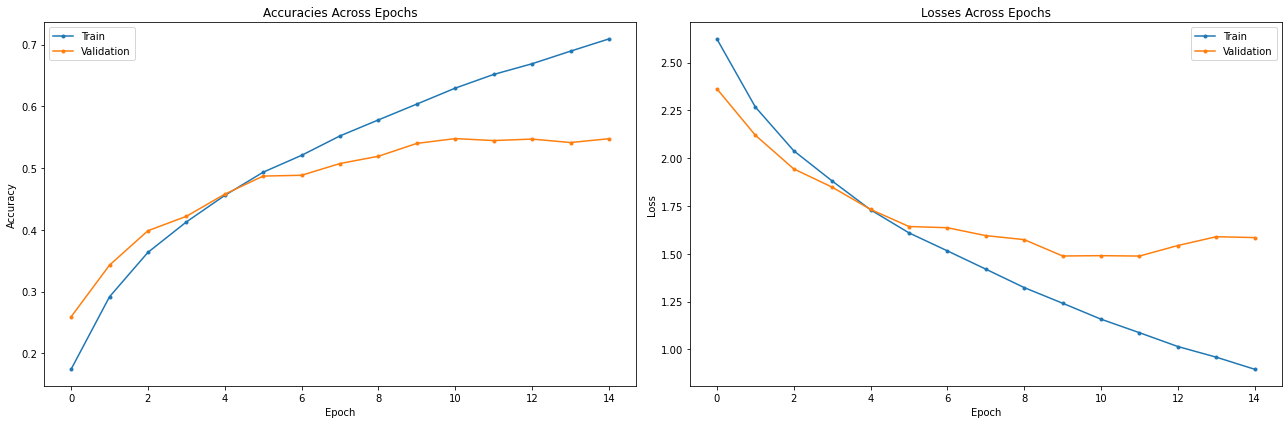

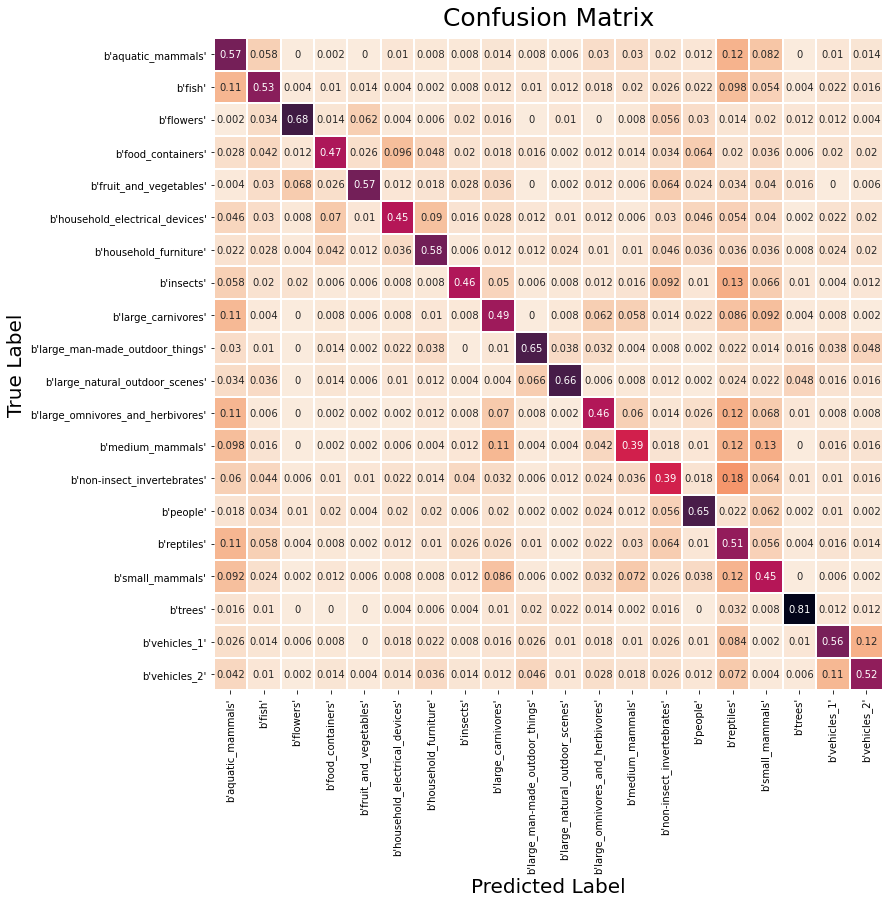

In [377]:
CNN_model3 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model3.add(Conv2D(128, kernel_size=(3, 3), activation = 'relu', input_shape = (32,32,3)))
CNN_model3.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model3.add(Dropout(0.2))

CNN_model3.add(Conv2D(256, kernel_size=(3, 3), activation = 'relu'))
CNN_model3.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model3.add(Dropout(0.2))

CNN_model3.add(Conv2D(512, kernel_size=(3, 3), activation = 'relu'))
CNN_model3.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model3.add(Dropout(0.2))

# Flatten the output of our convolutional layers
CNN_model3.add(Flatten())

# Add dense layers
CNN_model3.add(Dense(512, activation= 'relu'))
CNN_model3.add(Dense(256, activation= 'relu'))
CNN_model3.add(Dense(128, activation= 'relu'))
CNN_model3.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Print out a summary of the network
CNN_model3.summary()

# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN_model3.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
CNN3 = CNN_model3.fit(X_train, y_train,
              batch_size = 128,
              epochs = 50,
              verbose = 1,
              validation_split = 0.2,
                callbacks = ES)



test_loss_score(CNN_model3)
accuracy_loss_plots(CNN3)
confusion(CNN_model3)
CNN_model3.save('CNNmodels/CNN_model3.h5')

##### CNN 1 - Model 4

In Model 3, we increased the number of filters in each layer, and unfortunately the accuracy has not improved. In fact, the model started to overfit at 4th epoch. I wonder what would happen we change the dropout rates in each layer.

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 30, 30, 128)       3584      
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_93 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 13, 13, 256)       295168    
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
dropout_94 (Dropout)         (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 4, 4, 512)       

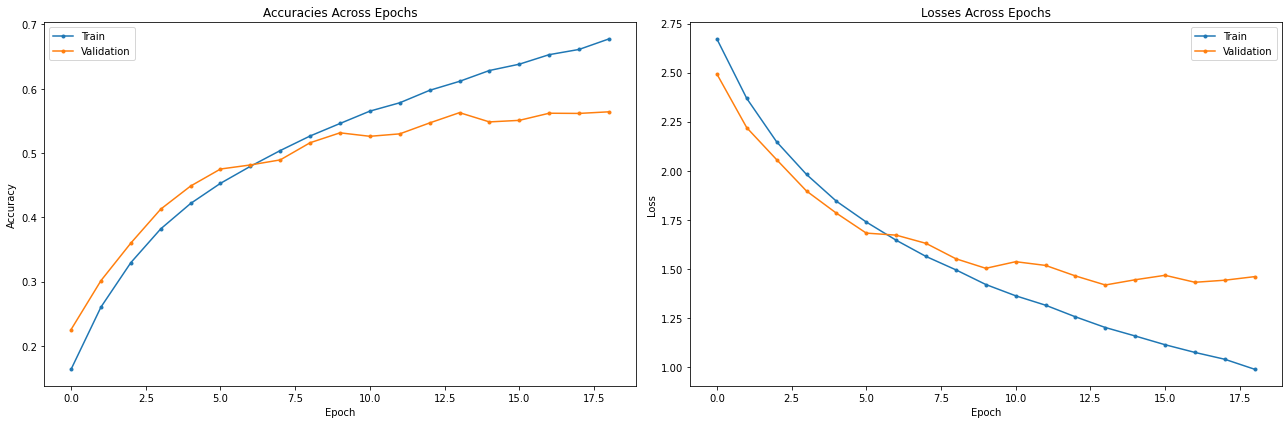

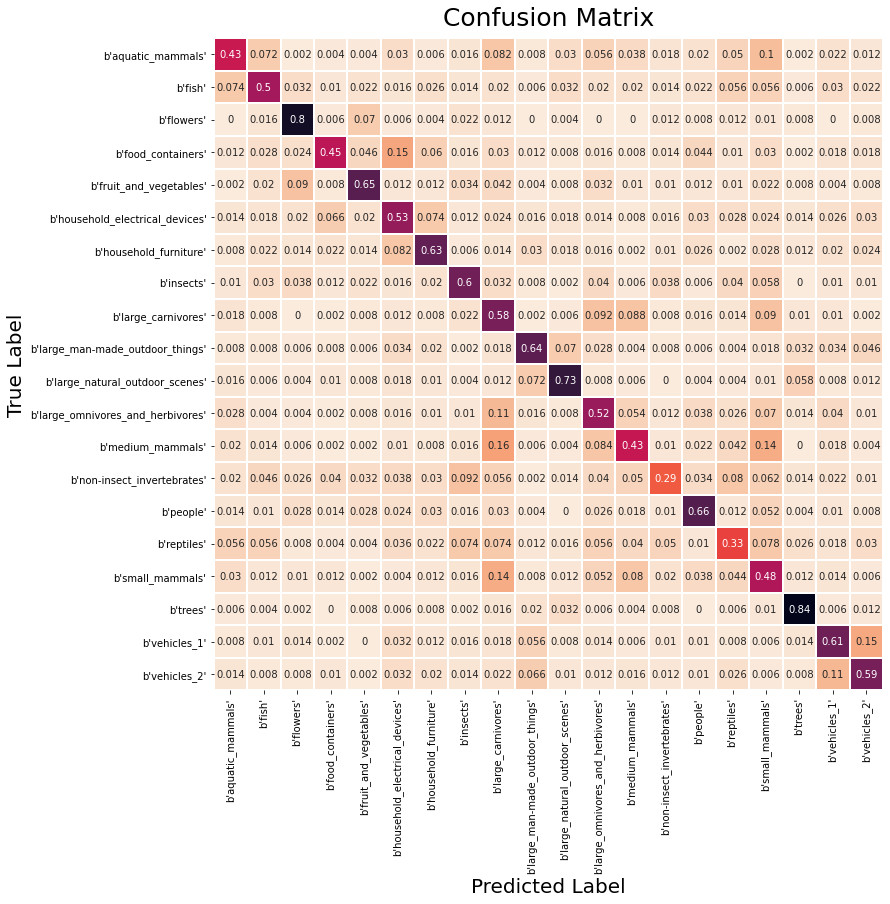

In [378]:

CNN_model4 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model4.add(Conv2D(128, kernel_size=(3, 3), activation = 'relu', input_shape = (32,32,3)))
CNN_model4.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model4.add(Dropout(0.1))

CNN_model4.add(Conv2D(256, kernel_size=(3, 3), activation = 'relu'))
CNN_model4.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model4.add(Dropout(0.2))

CNN_model4.add(Conv2D(512, kernel_size=(3, 3), activation = 'relu'))
CNN_model4.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model4.add(Dropout(0.4))

# Flatten the output of our convolutional layers
CNN_model4.add(Flatten())

# Add dense layers
CNN_model4.add(Dense(512, activation= 'relu'))
CNN_model4.add(Dense(256, activation= 'relu'))
CNN_model4.add(Dense(128, activation= 'relu'))
CNN_model4.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Print out a summary of the network
CNN_model4.summary()

# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN_model4.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
CNN4 = CNN_model4.fit(X_train, y_train,
              batch_size = 128,
              epochs = 50,
              verbose = 1,
              validation_split = 0.2,
              callbacks = ES)

test_loss_score(CNN_model4)
accuracy_loss_plots(CNN4)
confusion(CNN_model4)
CNN_model4.save('CNNmodels/CNN_model4.h5')

This model has the highest accuracy score (57%) on the test set so far. In comparison to Model 2, which had the same number of dropout rates in each corresponding layers, Model 4 overfit much earlier due to the increased number of filters in each layer. Perhaps with the higher number of filters, the dropout rates should also be increased to reduce overfitting.

##### CNN 2 - Model 5

The above model does not seem to perform very differently after all the minor modifications. I found a research paper (https://arxiv.org/pdf/1511.07289.pdf) where there was very little preprocessing done and the model is relatively more replicable as it is not very deep. I will try to replicate the model as best as I could and see whether this will improve the accuracy. Note that the research paper uses the model to predict classes, not superclass.

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 28, 28, 192)       14592     
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 14, 14, 192)       0         
_________________________________________________________________
dropout_96 (Dropout)         (None, 14, 14, 192)       0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 14, 14, 192)       37056     
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 14, 14, 240)       414960    
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 7, 7, 240)         0         
_________________________________________________________________
dropout_97 (Dropout)         (None, 7, 7, 240)       

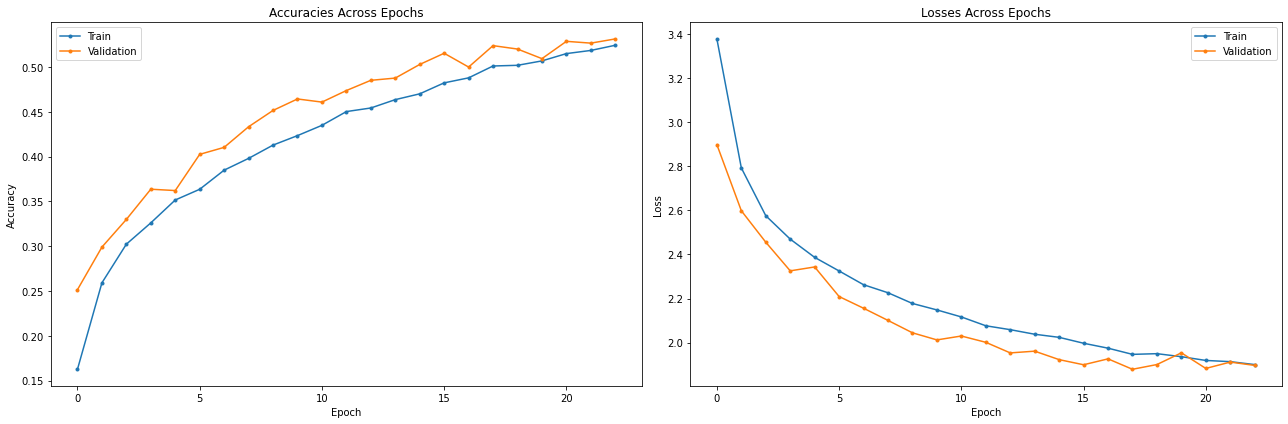

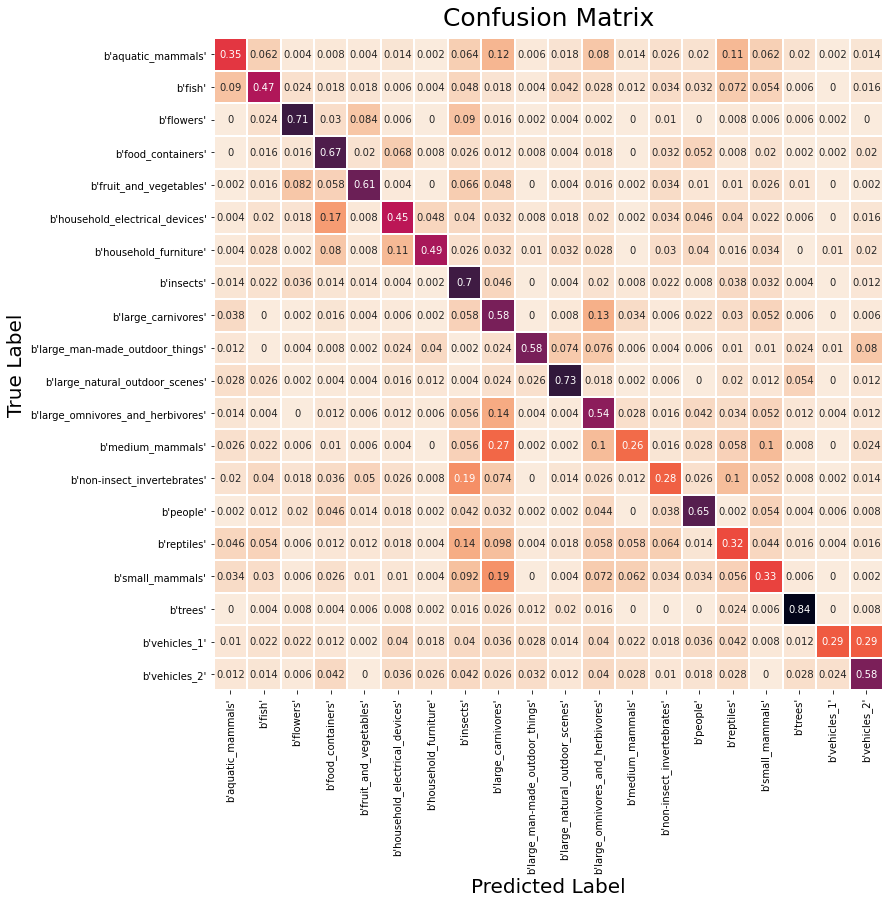

In [379]:
CNN_model5 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model5.add(Conv2D(192, kernel_size=(5, 5), activation = 'elu', input_shape = (32,32,3), kernel_regularizer=l2(0.0005))) 
CNN_model5.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model5.add(Dropout(0.0))

CNN_model5.add(Conv2D(192, kernel_size=(1, 1), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model5.add(Conv2D(240, kernel_size=(3, 3), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model5.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model5.add(Dropout(0.1))

CNN_model5.add(Conv2D(240, kernel_size=(1,1), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model5.add(Conv2D(260, kernel_size=(2,2), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model5.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model5.add(Dropout(0.2))

CNN_model5.add(Conv2D(260, kernel_size=(1,1), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model5.add(Conv2D(280, kernel_size=(2,2), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model5.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model5.add(Dropout(0.3))

CNN_model5.add(Conv2D(280, kernel_size=(1,1), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model5.add(Conv2D(300, kernel_size=(2,2), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model5.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model5.add(Dropout(0.4))

CNN_model5.add(Conv2D(300, kernel_size=(2,2), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model5.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model5.add(Dropout(0.5))

# Flatten the output of our convolutional layers
CNN_model5.add(Flatten())

# Add dense layers
CNN_model5.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Print out a summary of the network
CNN_model5.summary()

# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN_model5.compile(loss = 'sparse_categorical_crossentropy', #cross entropy is for multi-class classification
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
CNN5 = CNN_model5.fit(X_train, y_train,
              batch_size = 128,
              epochs = 100,
              verbose = 1,
              validation_split = 0.2,
              callbacks=ES)

test_loss_score(CNN_model5)
accuracy_loss_plots(CNN5)
confusion(CNN_model5)
CNN_model5.save('CNNmodels/CNN_model5.h5')

It looks like the validation and training accuracy were improving when the training was stopped. Perhaps, delaying the early stop would have yield better accuracy.

Also, interesting to note that some superclasses were significantly more confused. For example, 
- 27% of Medium Mammals and 19% of Small Mammals were confused as Large Carnivores
- 19% of Non-Insect Invertebrates was confused as Insects
- 29% of Vehicle 1 was confused as Vehicles 2

##### CNN 2 - Model 6

The previous model had a lot of filters in each layer. I wonder if accuracy will be jeopardized if the filters are reduced.

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_102 (Dropout)        (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 8, 8, 128)       

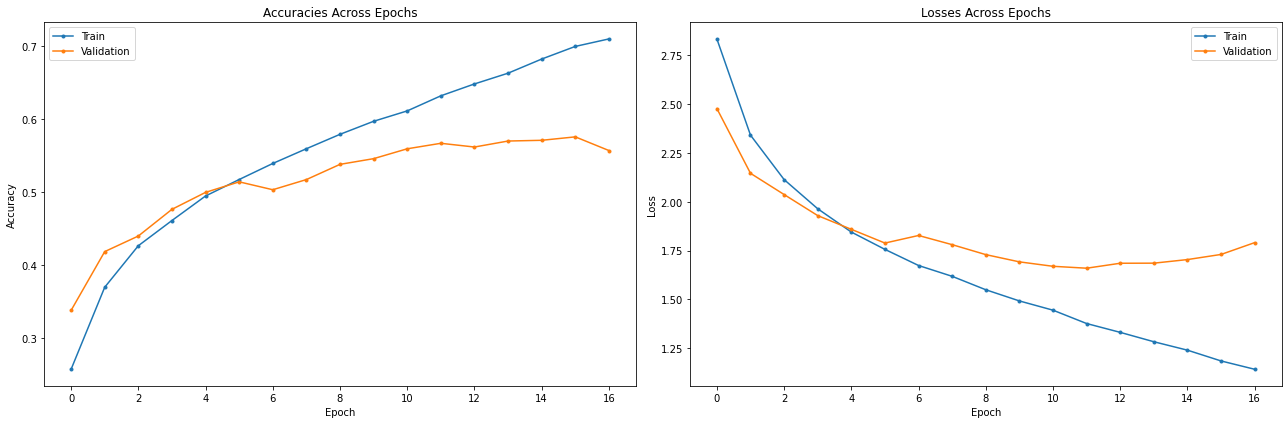

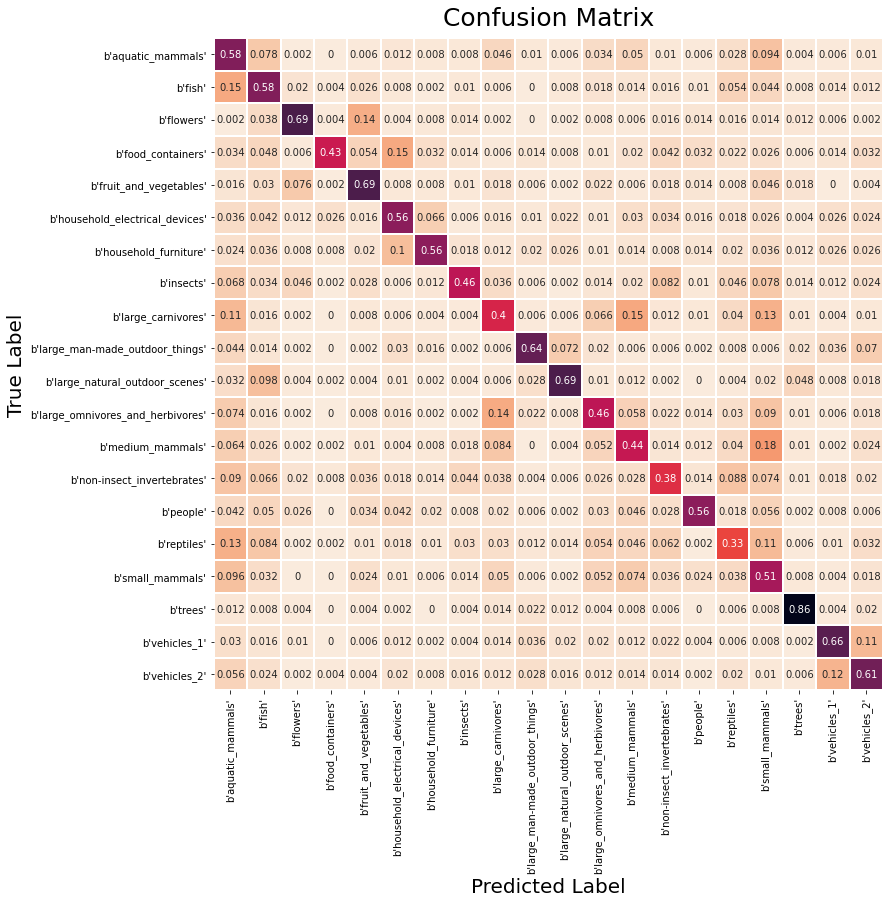

In [380]:
CNN_model6 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model6.add(Conv2D(32, kernel_size=(3,3), activation = 'elu', input_shape = (32,32,3), kernel_regularizer=l2(0.0005))) 
CNN_model6.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

CNN_model6.add(Conv2D(64, kernel_size=(3,3), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model6.add(Conv2D(128, kernel_size=(3,3), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model6.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model6.add(Dropout(0.1))

CNN_model6.add(Conv2D(128, kernel_size=(2,2), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model6.add(Conv2D(256, kernel_size=(2,2), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model6.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model6.add(Dropout(0.2))

CNN_model6.add(Conv2D(256, kernel_size=(1,1), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model6.add(Conv2D(512, kernel_size=(1,1), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model6.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model6.add(Dropout(0.3))

# Flatten the output of our convolutional layers
CNN_model6.add(Flatten())

# Add dense layers
CNN_model6.add(Dense(512, activation = 'elu'))
CNN_model6.add(Dense(256, activation = 'elu'))
CNN_model6.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Print out a summary of the network
CNN_model6.summary()

# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN_model6.compile(loss = 'sparse_categorical_crossentropy', #cross entropy is for multi-class classification
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
CNN6 = CNN_model6.fit(X_train, y_train,
              batch_size = 128,
              epochs = 100,
              verbose = 1,
              validation_split = 0.2,
                callbacks=ES)

test_loss_score(CNN_model6)
accuracy_loss_plots(CNN6)
confusion(CNN_model6)
save_format='h5'
CNN_model6.save('CNNmodels/CNN_model6.h5')

The accuracy decreased slightly after the number of filters are reduced.

Compared to Model 5, this model resulted in overfitting after 6 epochs which is much earlier. It has less filters in each convolutional layers but more dense layers than Model 5. A densely connected layer provides learning features from all the combinations of the features of the previous layer. Perhaps, increasing the number of dense layers have a negative effect on the accuracy. In the below model, we will replicate model 6 but remove all dense layers except for the last one.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         6

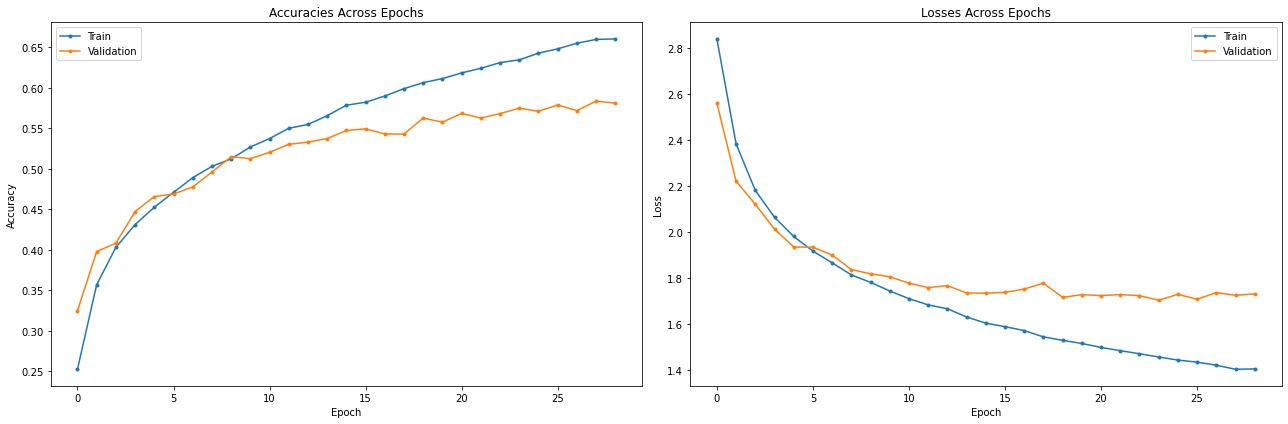

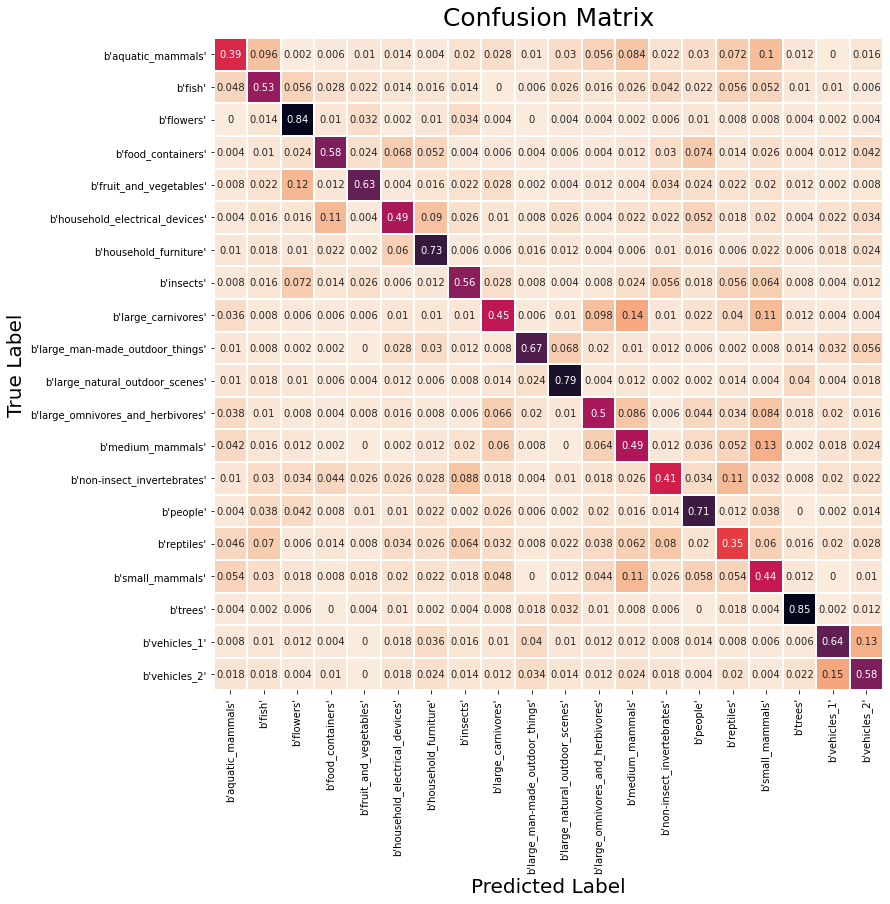

In [43]:
CNN_model6 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model6.add(Conv2D(32, kernel_size=(3,3), activation = 'elu', input_shape = (32,32,3), kernel_regularizer=l2(0.0005))) 
CNN_model6.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

CNN_model6.add(Conv2D(64, kernel_size=(3,3), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model6.add(Conv2D(128, kernel_size=(3,3), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model6.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model6.add(Dropout(0.1))

CNN_model6.add(Conv2D(128, kernel_size=(2,2), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model6.add(Conv2D(256, kernel_size=(2,2), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model6.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model6.add(Dropout(0.2))

CNN_model6.add(Conv2D(256, kernel_size=(1,1), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model6.add(Conv2D(512, kernel_size=(1,1), activation = 'elu', padding='same', kernel_regularizer=l2(0.0005)))
CNN_model6.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model6.add(Dropout(0.3))

# Flatten the output of our convolutional layers
CNN_model6.add(Flatten())

# Add dense layers 
CNN_model6.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Print out a summary of the network
CNN_model6.summary()

# Compile the model with the desired loss function, optimizer, and metric(s) to track
CNN_model6.compile(loss = 'sparse_categorical_crossentropy', #cross entropy is for multi-class classification
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
CNN6 = CNN_model6.fit(X_train, y_train,
              batch_size = 128,
              epochs = 100,
              verbose = 1,
              validation_split = 0.2,
                callbacks=ES)

test_loss_score(CNN_model6)
accuracy_loss_plots(CNN6)
confusion(CNN_model6)
save_format='h5'
CNN_model6.save('CNNmodels/CNN_model6.h5')

After removing the dense layers, the model overfit later and the accuracy on the test set reached 58%, which is highest by far. When comparing this with Model 5, there were less convolutional layers and the number of filters in the layers are less. However, this model is still overfitting much earlier than Model 5 despite the layer sizes were reduced! To reduce overfitting, we could perhaps increase the dropout rates in each layer.

##### ResNet - Model 7

Let's also try transfer learning to see how the prediction accuracy will do with very deep models.

In [200]:
model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   pooling='max',
                   input_shape=(32,32,3))

for layer in model.layers:
    layer.trainable = False
    
model.summary()


Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 18, 18, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

Epoch 1/50
313/313 [==============================] - 59s 190ms/step - loss: 2.5396 - accuracy: 0.2238 - val_loss: 2.4218 - val_accuracy: 0.2611
Epoch 2/50
313/313 [==============================] - 60s 191ms/step - loss: 2.2379 - accuracy: 0.3086 - val_loss: 2.3793 - val_accuracy: 0.2699
Epoch 3/50
313/313 [==============================] - 59s 189ms/step - loss: 1.9953 - accuracy: 0.3740 - val_loss: 2.4237 - val_accuracy: 0.2738
Epoch 4/50
313/313 [==============================] - 60s 192ms/step - loss: 1.7043 - accuracy: 0.4637 - val_loss: 2.6386 - val_accuracy: 0.2733
Epoch 5/50
313/313 [==============================] - 60s 191ms/step - loss: 1.3918 - accuracy: 0.5625 - val_loss: 2.9007 - val_accuracy: 0.2718
Epoch 6/50
313/313 [==============================] - 60s 192ms/step - loss: 1.0746 - accuracy: 0.6621 - val_loss: 3.4260 - val_accuracy: 0.2647
Epoch 7/50
313/313 [==============================] - 60s 193ms/step - loss: 0.8303 - accuracy: 0.7398 - val_loss: 3.9079 - val_ac

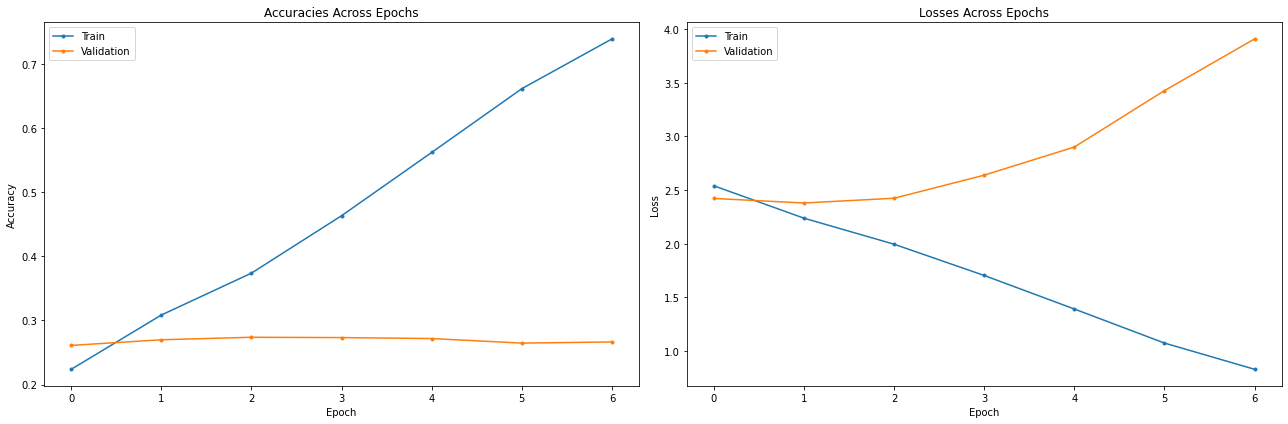

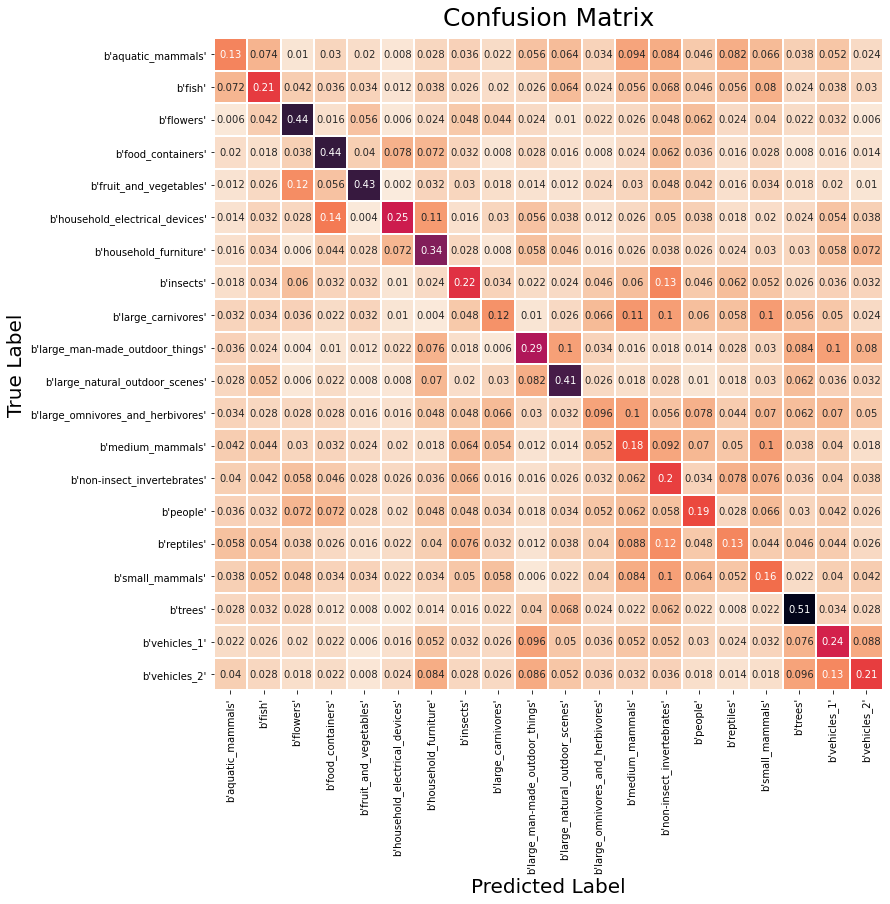

In [47]:
model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   pooling='max',
                   input_shape=(32,32,3))
for layer in model.layers:
    layer.trainable = False

    
RNmodel1 = Sequential()

RNmodel1.add(model)
RNmodel1.add(Flatten())
RNmodel1.add(Dense(2048, activation= 'relu'))
RNmodel1.add(Dense(1024, activation= 'relu'))
RNmodel1.add(Dense(512, activation= 'relu'))
RNmodel1.add(Dense(len(np.unique(y_train)), activation='softmax'))

RNmodel1.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

RN1 = RNmodel1.fit(X_train, y_train,
        batch_size = 128,
          epochs=50,
          validation_split=0.2,
         callbacks=ES)

test_loss_score(RNmodel1)
accuracy_loss_plots(RN1)
confusion(RNmodel1)
save_format='h5'
RNmodel1.save('CNNmodels/RNmodel1.h5')

There is a significant overfitting happening using ResNetV50. We will try to reduce the size of the final dense layers to reduce overfitting.

Epoch 1/50
313/313 [==============================] - 52s 167ms/step - loss: 2.7083 - accuracy: 0.1903 - val_loss: 2.5870 - val_accuracy: 0.2393
Epoch 2/50
313/313 [==============================] - 52s 166ms/step - loss: 2.4958 - accuracy: 0.2590 - val_loss: 2.5153 - val_accuracy: 0.2557
Epoch 3/50
313/313 [==============================] - 52s 165ms/step - loss: 2.4101 - accuracy: 0.2820 - val_loss: 2.4835 - val_accuracy: 0.2613
Epoch 4/50
313/313 [==============================] - 52s 165ms/step - loss: 2.3570 - accuracy: 0.2936 - val_loss: 2.4668 - val_accuracy: 0.2640
Epoch 5/50
313/313 [==============================] - 52s 165ms/step - loss: 2.3176 - accuracy: 0.3037 - val_loss: 2.4572 - val_accuracy: 0.2667
Epoch 6/50
313/313 [==============================] - 51s 163ms/step - loss: 2.2869 - accuracy: 0.3106 - val_loss: 2.4507 - val_accuracy: 0.2680
Epoch 7/50
313/313 [==============================] - 52s 166ms/step - loss: 2.2622 - accuracy: 0.3176 - val_loss: 2.4508 - val_ac

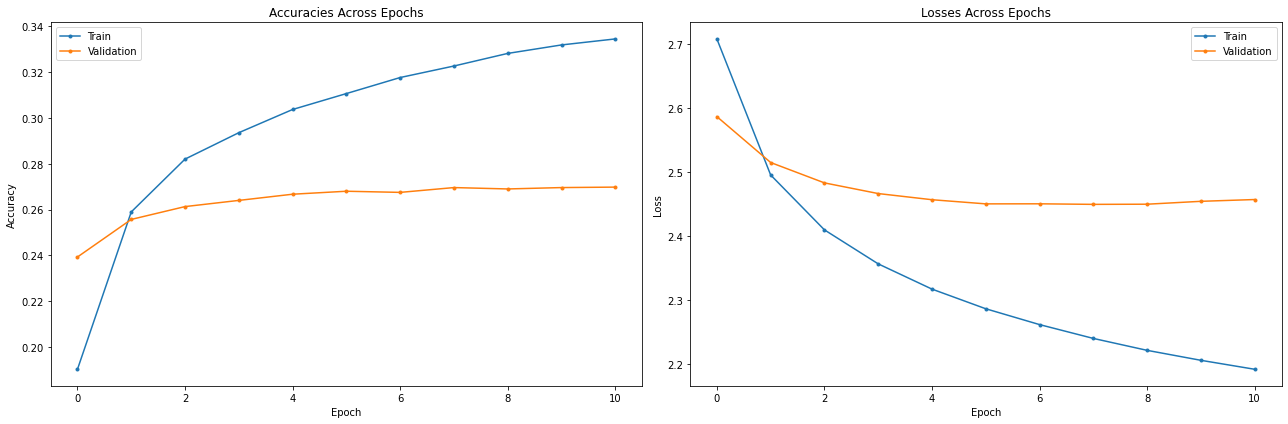

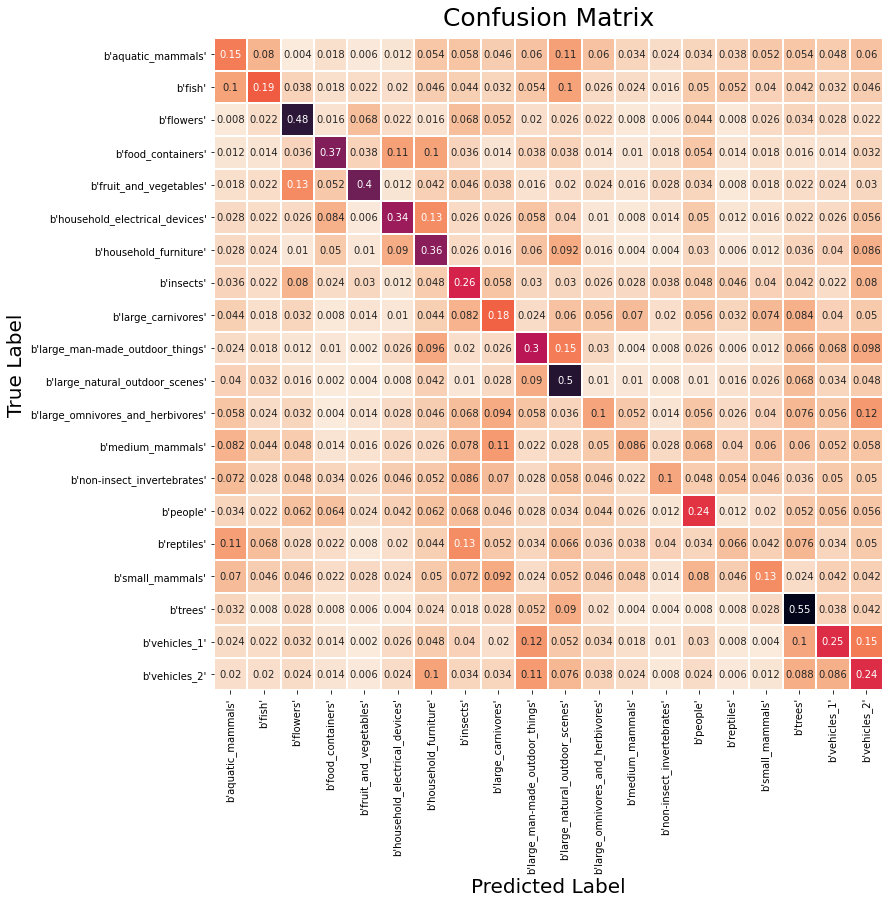

In [44]:
model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   pooling='max',
                   input_shape=(32,32,3))
for layer in model.layers:
    layer.trainable = False

    
RNmodel1 = Sequential()

RNmodel1.add(model)
RNmodel1.add(Flatten()) b
RNmodel1.add(Dense(len(np.unique(y_train)), activation='softmax'))

RNmodel1.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

RN1 = RNmodel1.fit(X_train, y_train,
        batch_size = 128,
          epochs=50,
          validation_split=0.2,
         callbacks=ES)

test_loss_score(RNmodel1)
accuracy_loss_plots(RN1)
confusion(RNmodel1)
save_format='h5'
RNmodel1.save('CNNmodels/RNmodel1.h5')

Overfitting is not corrected after removing the dense layers. Perhaps, ResNetV50 is just not suitable for the dataset given that ResNetV50 was trained on images with higher resolutions, whereas the images in our dataset are low resolution. ResNetV50 might have over-analyzed the images when there are not that much info in the low resolution images. This might be the reason for overfitting so early.

##### VGG16 - Model 8

In [207]:
model = VGG16(weights='imagenet',
                   include_top=False,
                   pooling='max',
                   input_shape=(32,32,3))

for layer in model.layers:
    layer.trainable = False
    
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

Epoch 1/50
313/313 [==============================] - 152s 485ms/step - loss: 2.0465 - accuracy: 0.3598 - val_loss: 1.8821 - val_accuracy: 0.4154
Epoch 2/50
313/313 [==============================] - 155s 495ms/step - loss: 1.7461 - accuracy: 0.4503 - val_loss: 1.7512 - val_accuracy: 0.4533
Epoch 3/50
313/313 [==============================] - 153s 490ms/step - loss: 1.6060 - accuracy: 0.4917 - val_loss: 1.7070 - val_accuracy: 0.4632
Epoch 4/50
313/313 [==============================] - 153s 487ms/step - loss: 1.4906 - accuracy: 0.5256 - val_loss: 1.6900 - val_accuracy: 0.4751
Epoch 5/50
313/313 [==============================] - 153s 489ms/step - loss: 1.3745 - accuracy: 0.5602 - val_loss: 1.6951 - val_accuracy: 0.4833
Epoch 6/50
313/313 [==============================] - 155s 494ms/step - loss: 1.2677 - accuracy: 0.5899 - val_loss: 1.7566 - val_accuracy: 0.4779
Epoch 7/50
313/313 [==============================] - 154s 493ms/step - loss: 1.1493 - accuracy: 0.6279 - val_loss: 1.7975 -

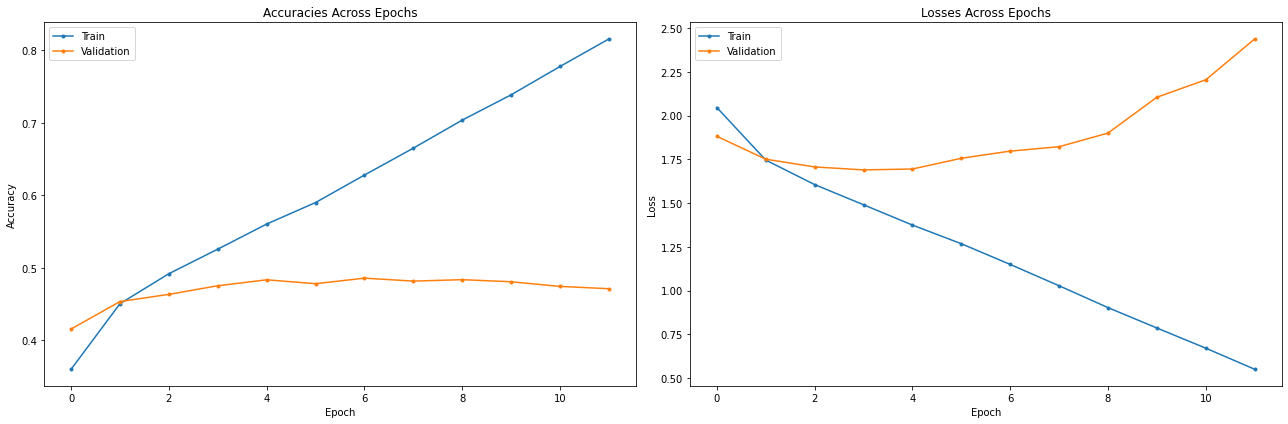

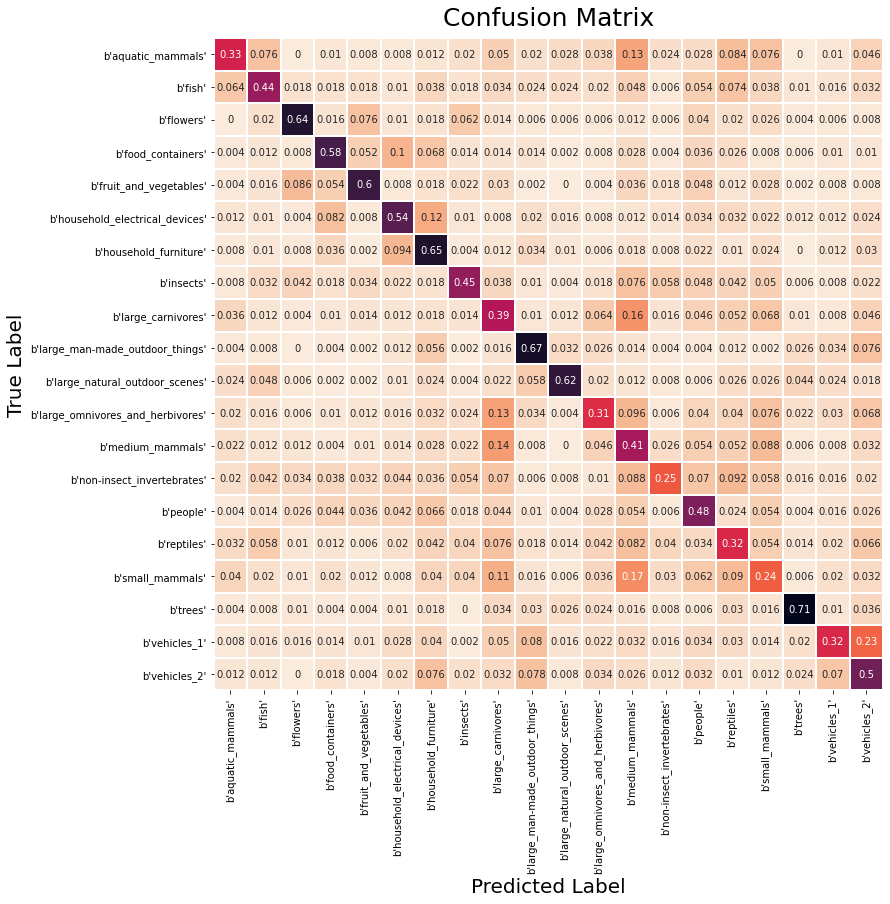

In [209]:
model = VGG16(weights='imagenet',
                   include_top=False,
                   pooling='max',
                   input_shape=(32,32,3))

for layer in model.layers:
    layer.trainable = False
    
VGmodel1 = Sequential()

VGmodel1.add(model)
VGmodel1.add(Flatten())
VGmodel1.add(Dense(512, activation= 'relu'))
VGmodel1.add(Dense(256, activation= 'relu'))
VGmodel1.add(Dense(128, activation= 'relu'))
VGmodel1.add(Dense(len(np.unique(y_train)), activation='softmax'))

VGmodel1.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

VG1 = VGmodel1.fit(X_train, y_train,
        batch_size = 128,
          epochs=50,
          validation_split=0.2,
            callbacks = ES)

test_loss_score(VGmodel1)
accuracy_loss_plots(VG1)
confusion(VGmodel1)
save_format='h5'
VGmodel1.save('CNNmodels/VGmodel1.h5')

Similar to ResNetV50, there is also significant overfitting with VGG16. We will remove the dense layers to see if this will reduce overfitting. The interesting thing here is that VGG16 was doing extremely well on the train set, reaching to 80% accuracy on the train set. However, validation set shows that the learning of train set was not helpful in recognizing the validation set. This also suggests that VGG16 perhaps have over-analyzed on the features of train set.

Epoch 1/50
313/313 [==============================] - 117s 374ms/step - loss: 2.4070 - accuracy: 0.2722 - val_loss: 2.1455 - val_accuracy: 0.3505
Epoch 2/50
313/313 [==============================] - 117s 375ms/step - loss: 2.0663 - accuracy: 0.3696 - val_loss: 2.0192 - val_accuracy: 0.3859
Epoch 3/50
313/313 [==============================] - 117s 374ms/step - loss: 1.9685 - accuracy: 0.3975 - val_loss: 1.9537 - val_accuracy: 0.4001
Epoch 4/50
313/313 [==============================] - 117s 374ms/step - loss: 1.9114 - accuracy: 0.4126 - val_loss: 1.9154 - val_accuracy: 0.4130
Epoch 5/50
313/313 [==============================] - 118s 377ms/step - loss: 1.8718 - accuracy: 0.4250 - val_loss: 1.8884 - val_accuracy: 0.4173
Epoch 6/50
313/313 [==============================] - 117s 373ms/step - loss: 1.8421 - accuracy: 0.4325 - val_loss: 1.8666 - val_accuracy: 0.4285
Epoch 7/50
313/313 [==============================] - 117s 373ms/step - loss: 1.8186 - accuracy: 0.4387 - val_loss: 1.8532 -

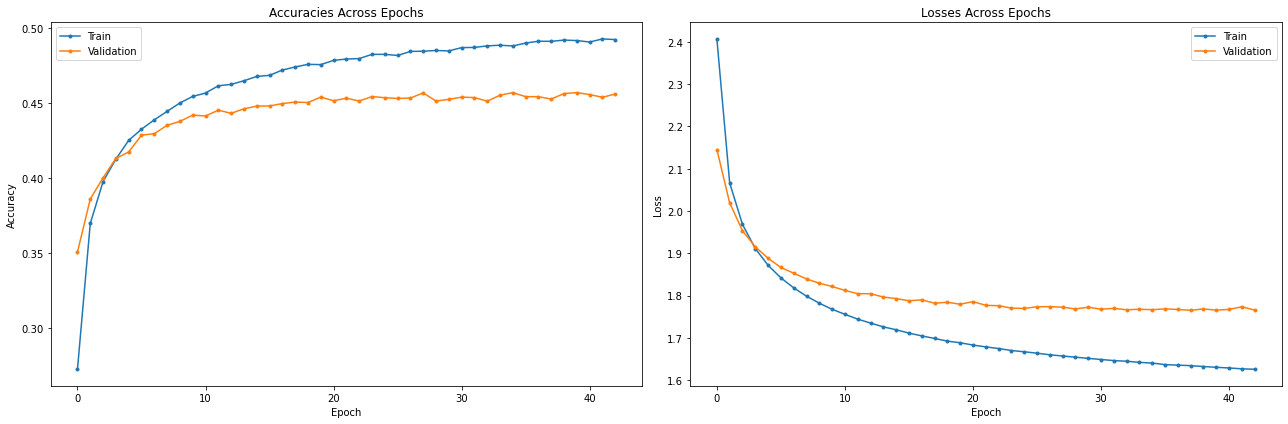

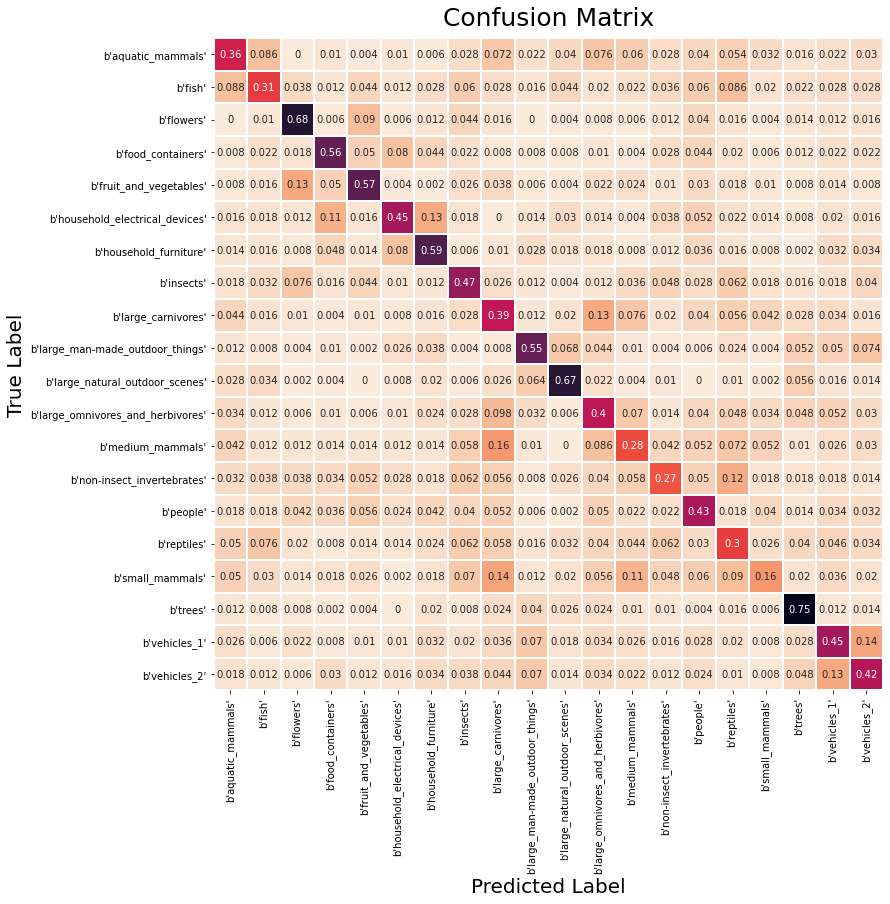

In [46]:
model = VGG16(weights='imagenet',
                   include_top=False,
                   pooling='max',
                   input_shape=(32,32,3))

for layer in model.layers:
    layer.trainable = False
    
VGmodel1 = Sequential()

VGmodel1.add(model)
VGmodel1.add(Flatten())
VGmodel1.add(Dense(len(np.unique(y_train)), activation='softmax'))

VGmodel1.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

VG1 = VGmodel1.fit(X_train, y_train,
        batch_size = 128,
          epochs=50,
          validation_split=0.2,
            callbacks = ES)

test_loss_score(VGmodel1)
accuracy_loss_plots(VG1)
confusion(VGmodel1)
save_format='h5'
VGmodel1.save('CNNmodels/VGmodel1.h5')

Removing most of the dense layers have reduced overfitting. The accuracy on the train set maxed out around 50%, suggesting that removing the dense layer reduced the over-analyzing we saw in the previous try of VGG16. However, removing the dense layer did not help with increasing the accuracy on the test set.

In conclusion, ResNet50 and VGG16 were much deeper than all previous models, however, they yield a much lower accuracy especially ResNetV50. The reason could related to the fact that these transfer learning models were trained on ImageNet which has an average image resolution of 469 x 387 pixels. The default input size for ResNet and VGG16 is 224 x 224, while the images in this dataset is 32 x 32. Therefore, ResNet and VGG16 might not be appropriate for this dataset, hence the not-so-great accuracy.

## Color -  Superclass (Augmented)

From the above CNN models, we will move forward with Model 2 and Model 4 as they yielded the highest accuracy out of all.

### Attempt 1 - Set up Data Augmentation 

In [33]:
# Set our X_train, y_train and X_test, y_test

X_train = Train_data
y_train = Train_coarse #set coarse/superclass as our classification target

X_test = Test_data
y_test = Test_coarse

# Create training image data generator
train_datagen = ImageDataGenerator(rotation_range = 30,
                                   horizontal_flip=True,
                                   validation_split=0.2)

 
train_generator=train_datagen.flow(X_train, y_train, shuffle=False, batch_size=128, subset='training')
validation_generator = train_datagen.flow(X_train, y_train, shuffle=False, batch_size=128, subset='validation')
 
ES = EarlyStopping(monitor='val_loss', patience=5, mode='auto', min_delta=0.0001, verbose=1)

The `train_generator` consisted of 313 tuple of image data (X) and y (class). In each set of tuple except for the last one, there are 128 images which corresponds to the batch size we set. The last set contains only 64 images. In total, there are 40,000 images (312 x 128 + 1 x 64) for training.

In [30]:
len(train_generator)

313

In [31]:
X, y = train_generator[312]
len(X)

64

In the CNN models below, we yielded some very low accuracy scores and perhaps the classes in the train/validation set is not stratified properly. We will check it below.

In [32]:
# find out if the classes are stratified in the train_generator


# create dataframe to store the count
class_in_train = pd.DataFrame(np.zeros((1, 20)))

# loop through train_generator and count classes
for i in range(len(train_generator)):
    X, y = train_generator[i]
    for n in range(len(y)):
        count = class_in_train[int(y[n])]
        class_in_train[int(y[n])] = count + 1

# Print df
class_in_train.T
    

0
0   1967.0
1   2008.0
2   1989.0
3   2006.0
4   1986.0
5   2001.0
6   1995.0
7   2034.0
8   2025.0
9   2044.0
10  2000.0
11  1988.0
12  1969.0
13  1991.0
14  2002.0
15  2010.0
16  2020.0
17  2017.0
18  1961.0
19  1987.0

In [33]:
class_in_train.T.sum(axis=0)

0    40000.0
dtype: float64

We expect 2000 images per class, so the class are relatively balance. 

The `validation_generator` consisted of 79 tuple of image data (X) and y (class). In each set of tuple except for the last one, there are 128 images which corresponds to the batch size we set. The last set contains only 16 images. In total, there are 10,000 images (78 x 128 + 1 x 16) for training. This corresponds to the 20% validation split we set.

In [34]:
len(validation_generator)

79

In [35]:
X, y = validation_generator[78]
len(X)

16

In [36]:
# find out if the classes are stratifiedb in the validation_generator


# create dataframe to store the count
class_in_validation = pd.DataFrame(np.zeros((1, 20)))

# loop through validation_generator and count classes
for i in range(len(validation_generator)):
    X, y = validation_generator[i]
    for n in range(len(y)):
        count = class_in_validation[int(y[n])]
        class_in_validation[int(y[n])] = count + 1

# Print df
class_in_validation.T

0
0   533.0
1   492.0
2   511.0
3   494.0
4   514.0
5   499.0
6   505.0
7   466.0
8   475.0
9   456.0
10  500.0
11  512.0
12  531.0
13  509.0
14  498.0
15  490.0
16  480.0
17  483.0
18  539.0
19  513.0

We expect 500 images per class, so the classes seem balance for the most part.

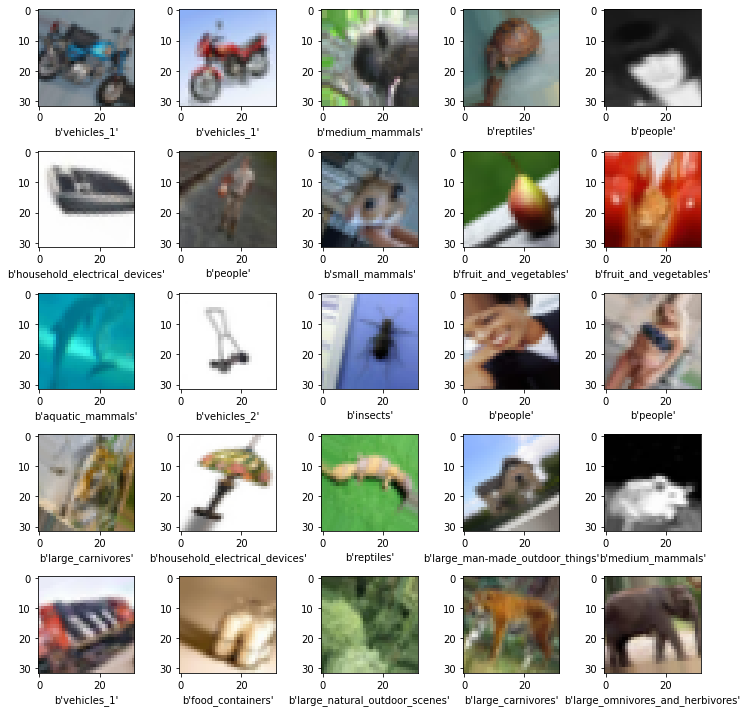

In [37]:
# Print random images from train generator

# Create subplots

plt.subplots(5,5, figsize=(10,10))


for i in range(25):
    X, y = train_generator[i]
    image = X[i]
    title = Superclass_label.iloc[int(y[i])]['Superclass_label']
    plt.subplot(5,5,i+1) 
    plt.xlabel(title)
    plt.imshow(image)   

plt.tight_layout()
plt.show()


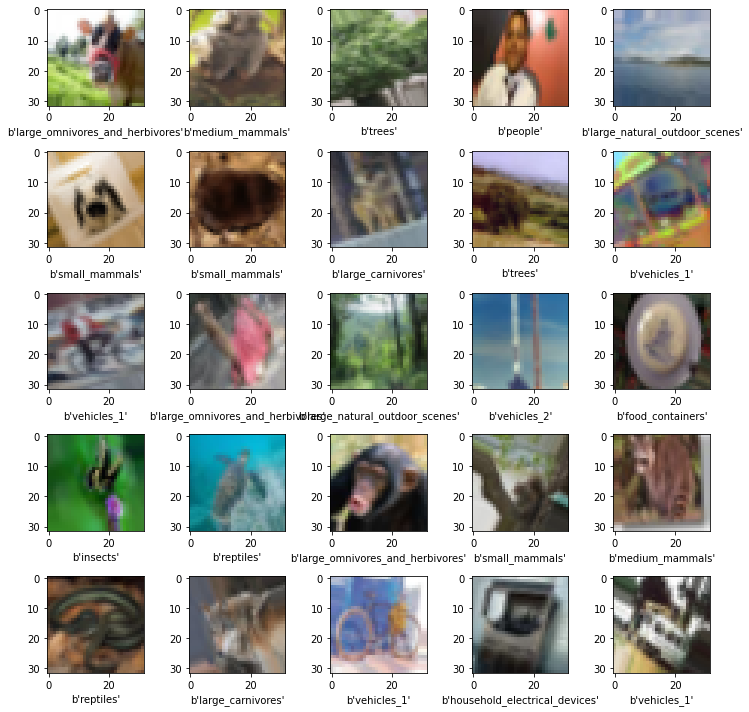

In [38]:
# Print random images from validation generator

# Create subplots

plt.subplots(5,5, figsize=(10,10))


for i in range(25):
    X, y = validation_generator[i]
    image = X[i]
    title = Superclass_label.iloc[int(y[i])]['Superclass_label']
    plt.subplot(5,5,i+1) 
    plt.xlabel(title)
    plt.imshow(image)   

plt.tight_layout()
plt.show()

##### ACNN 1 - Model 2

I will run the 2 best models from above on the augmented data.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 256)        

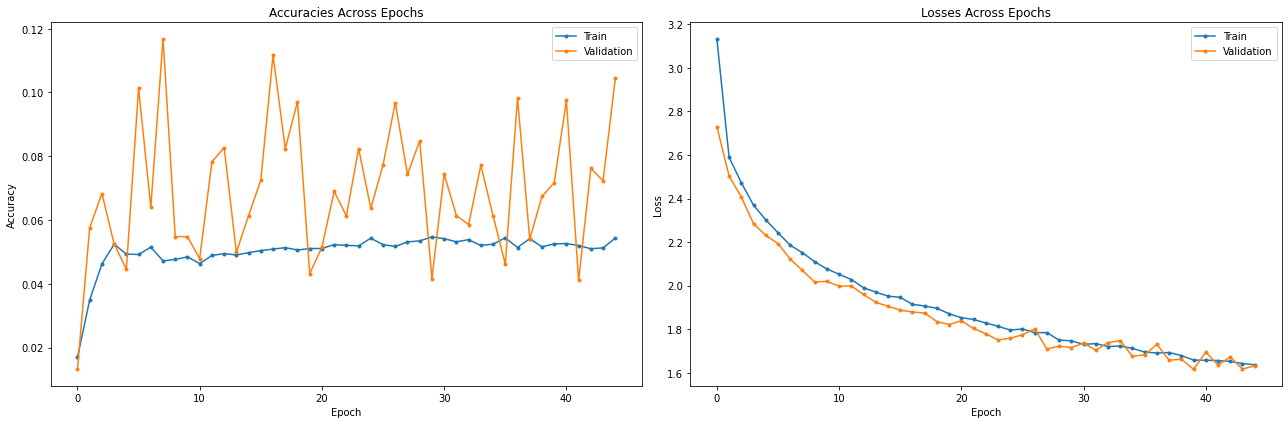

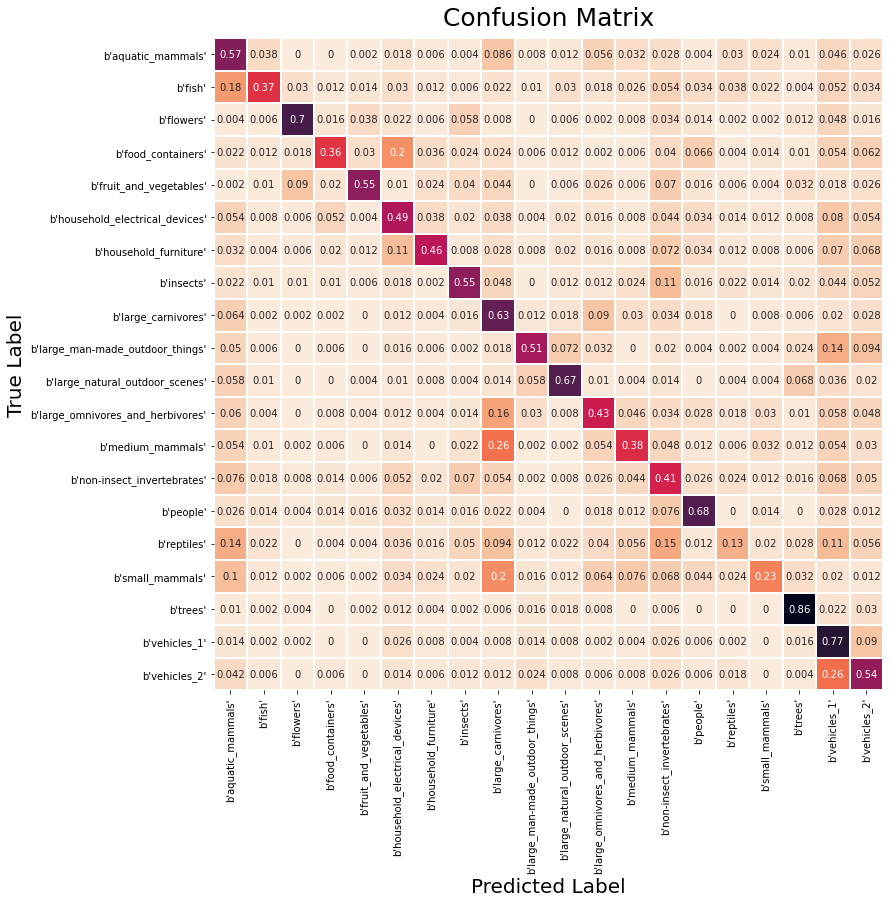

In [49]:
ACNN_model2 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
ACNN_model2.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (32,32,3)))
ACNN_model2.add(MaxPooling2D(pool_size=(2, 2)))
ACNN_model2.add(Dropout(0.1))

ACNN_model2.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu'))
ACNN_model2.add(MaxPooling2D(pool_size=(2, 2)))
ACNN_model2.add(Dropout(0.2))

ACNN_model2.add(Conv2D(256, kernel_size=(3, 3), activation = 'relu'))
ACNN_model2.add(MaxPooling2D(pool_size=(2, 2)))
ACNN_model2.add(Dropout(0.4))

# Flatten the output of our convolutional layers
ACNN_model2.add(Flatten())

# Add dense layers
ACNN_model2.add(Dense(256, activation= 'relu'))
ACNN_model2.add(Dense(64, activation= 'relu'))
ACNN_model2.add(Dense(32, activation= 'relu'))
ACNN_model2.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Print out a summary of the network
ACNN_model2.summary()

# Compile the model with the desired loss function, optimizer, and metric(s) to track
ACNN_model2.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
ACNN2 = ACNN_model2.fit(train_generator,
                          epochs = 50,
                          verbose = 1,
                          validation_data = validation_generator,
                            callbacks = ES)

test_loss_score(ACNN_model2)
accuracy_loss_plots(ACNN2)
confusion(ACNN_model2)
save_format='h5'
ACNN_model2.save('CNNmodels/ACNN_model2.h5')

In [36]:
model = load_model('CNNmodels/ACNN_model2.h5')

**See section 3.2.2 for the reason we use `classification_report` to check the accuracy of model on test set.**

In [37]:
from sklearn.metrics import classification_report

# get the classification report and turn into dataframe
predict_probas = model.predict(X_test)
y_predict = np.argmax(predict_probas, axis=1)
report = pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).T

In [38]:
report

precision  recall  f1-score     support
0              0.360303  0.5700  0.441518    500.0000
1              0.654930  0.3720  0.474490    500.0000
2              0.791383  0.6980  0.741764    500.0000
3              0.648746  0.3620  0.464698    500.0000
4              0.792507  0.5500  0.649351    500.0000
5              0.420415  0.4860  0.450835    500.0000
6              0.660000  0.4620  0.543529    500.0000
7              0.582979  0.5480  0.564948    500.0000
8              0.356580  0.6340  0.456443    500.0000
9              0.691257  0.5060  0.584296    500.0000
10             0.696281  0.6740  0.684959    500.0000
11             0.461039  0.4260  0.442827    500.0000
12             0.491049  0.3840  0.430976    500.0000
13             0.299410  0.4060  0.344652    500.0000
14             0.644487  0.6780  0.660819    500.0000
15             0.368715  0.1320  0.194404    500.0000
16             0.502222  0.2260  0.311724    500.0000
17             0.729592  0.8580  0.788603    500.0000
18             0.384384  0.7680  0.512342    500.0000
19             0.399703  0.5380  0.458653    500.0000
accuracy       0.513900  0.5139  0.513900      0.5139
macro avg      0.546799  0.5139  0.510092  10000.0000
weighted avg   0.546799  0.5139  0.510092  10000.0000

The accuracy on test set is around 51%.

##### ACNN 1 - Model 4

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 256)       295168    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 512)        

Epoch 42/50
313/313 [==============================] - 134s 427ms/step - loss: 1.4985 - accuracy: 0.0476 - val_loss: 1.5804 - val_accuracy: 0.0650
Epoch 43/50
313/313 [==============================] - 133s 426ms/step - loss: 1.4896 - accuracy: 0.0484 - val_loss: 1.6063 - val_accuracy: 0.0565
Epoch 44/50
313/313 [==============================] - 133s 426ms/step - loss: 1.4924 - accuracy: 0.0487 - val_loss: 1.6184 - val_accuracy: 0.0578
Epoch 45/50
313/313 [==============================] - 133s 426ms/step - loss: 1.4799 - accuracy: 0.0463 - val_loss: 1.5914 - val_accuracy: 0.0525
Epoch 46/50
313/313 [==============================] - 134s 427ms/step - loss: 1.4747 - accuracy: 0.0472 - val_loss: 1.5909 - val_accuracy: 0.0665
Epoch 47/50
313/313 [==============================] - 134s 429ms/step - loss: 1.4608 - accuracy: 0.0473 - val_loss: 1.5977 - val_accuracy: 0.0420
Epoch 00047: early stopping
Test loss: 1.5761479139328003
Test accuracy: 0.03060000017285347

 



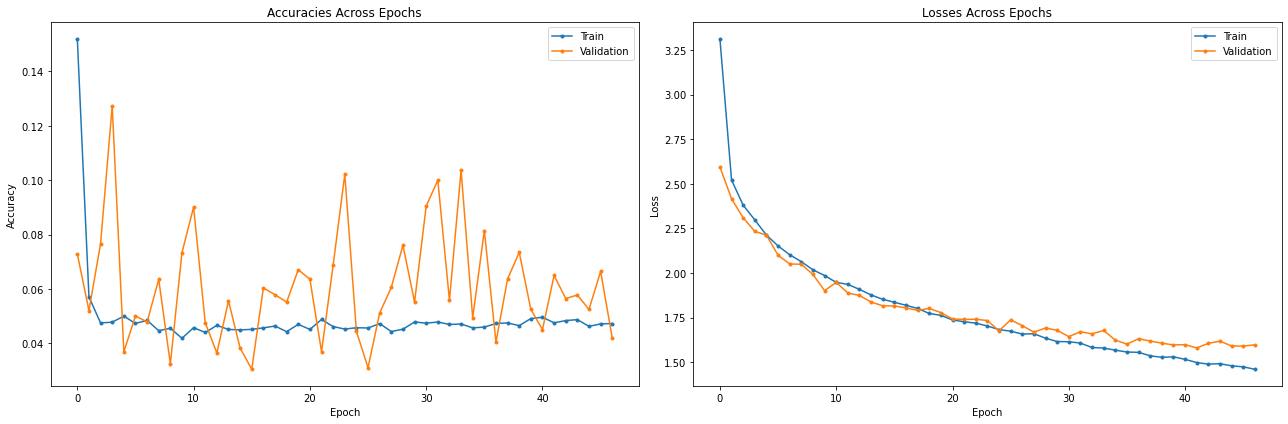

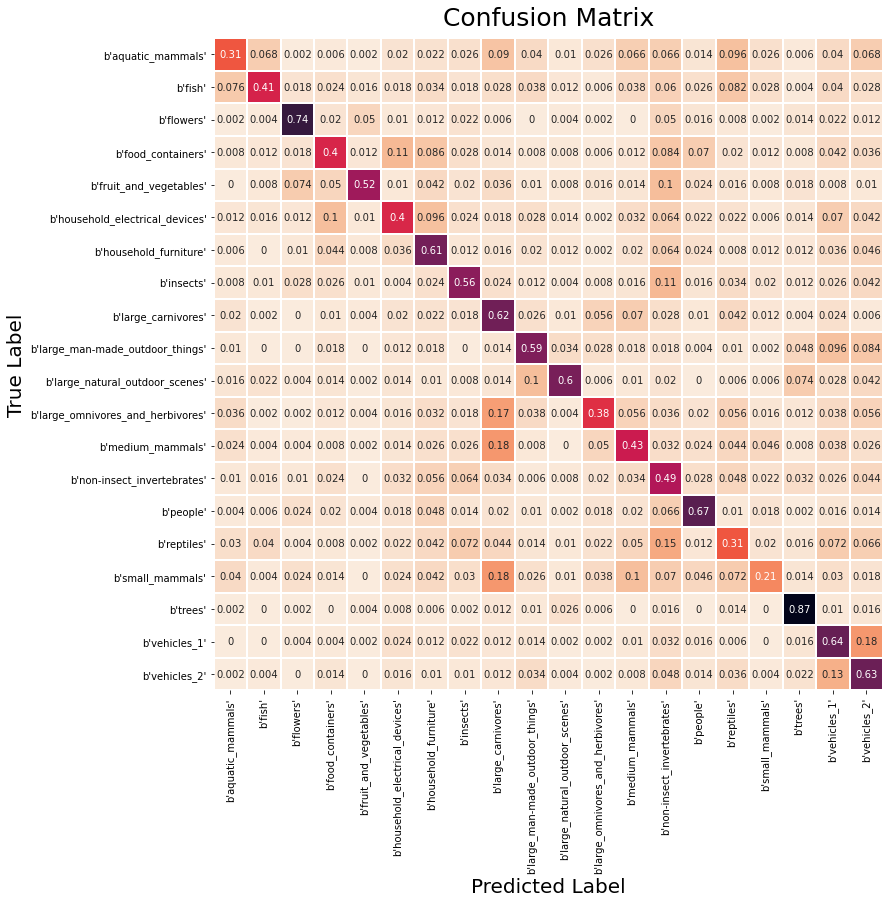

In [50]:

ACNN_model4 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
ACNN_model4.add(Conv2D(128, kernel_size=(3, 3), activation = 'relu', input_shape = (32,32,3)))
ACNN_model4.add(MaxPooling2D(pool_size=(2, 2)))
ACNN_model4.add(Dropout(0.1))

ACNN_model4.add(Conv2D(256, kernel_size=(3, 3), activation = 'relu'))
ACNN_model4.add(MaxPooling2D(pool_size=(2, 2)))
ACNN_model4.add(Dropout(0.2))

ACNN_model4.add(Conv2D(512, kernel_size=(3, 3), activation = 'relu'))
ACNN_model4.add(MaxPooling2D(pool_size=(2, 2)))
ACNN_model4.add(Dropout(0.4))

# Flatten the output of our convolutional layers
ACNN_model4.add(Flatten())

# Add dense layers
ACNN_model4.add(Dense(512, activation= 'relu'))
ACNN_model4.add(Dense(256, activation= 'relu'))
ACNN_model4.add(Dense(128, activation= 'relu'))
ACNN_model4.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Print out a summary of the network
ACNN_model4.summary()

# Compile the model with the desired loss function, optimizer, and metric(s) to track
ACNN_model4.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
ACNN4 = ACNN_model4.fit(train_generator,
                          epochs = 50,
                          verbose = 1,
                          validation_data = validation_generator,
                            callbacks = ES)



test_loss_score(ACNN_model4)
accuracy_loss_plots(ACNN4)
confusion(ACNN_model4)

save_format='h5'
ACNN_model4.save('CNNmodels/ACNN_model4.h5')

In [29]:
# Save model

model = load_model('CNNmodels/ACNN_model4.h5')

In [34]:
from sklearn.metrics import classification_report

# get the classification report and turn into dataframe
predict_probas = model.predict(X_test)
y_predict = np.argmax(predict_probas, axis=1)
report = pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).T

In [35]:
report

precision  recall  f1-score     support
0              0.500000  0.3060  0.379653    500.0000
1              0.650641  0.4060  0.500000    500.0000
2              0.756098  0.7440  0.750000    500.0000
3              0.491443  0.4020  0.442244    500.0000
4              0.798780  0.5240  0.632850    500.0000
5              0.478261  0.3960  0.433260    500.0000
6              0.488818  0.6120  0.543517    500.0000
7              0.564257  0.5620  0.563126    500.0000
8              0.397933  0.6160  0.483516    500.0000
9              0.567829  0.5860  0.576772    500.0000
10             0.767263  0.6000  0.673401    500.0000
11             0.543353  0.3760  0.444444    500.0000
12             0.429423  0.4320  0.430708    500.0000
13             0.302615  0.4860  0.372985    500.0000
14             0.633080  0.6660  0.649123    500.0000
15             0.326923  0.3060  0.316116    500.0000
16             0.451477  0.2140  0.290366    500.0000
17             0.720466  0.8660  0.786558    500.0000
18             0.444909  0.6380  0.524240    500.0000
19             0.427012  0.6260  0.507705    500.0000
accuracy       0.518200  0.5182  0.518200      0.5182
macro avg      0.537029  0.5182  0.515029  10000.0000
weighted avg   0.537029  0.5182  0.515029  10000.0000

This model has a 52% accuracy on the test set, so `Model 4` seems to yield better prediction accuracy compared to `Model 2`. As such, for the 100 classes, we will attempt `Model 4`.

### Attempt 2 - Set up Data Augmentation 

The models above yielded strange results where the loss decreases in each epoch but accuracy did not improve. What is more strange is the confusion matrix shows pretty good accuracy for each superclass. To see if we can pinpoint what happened, we will narrow down our train/validation/test to only two classes and see whether the models will perform properly. Although I will use the `ImageDataGenerator`, I will not add any augmentation to the data except for splitting the dataset into train/validation. We will pick trees and people, as they are quite different and should not be too difficult for the model to learn the difference!

In [200]:
# Need to find all indices that matches to superclass 14(people) and 17(trees)

# create list to store all indices of tree/people
tree_people_index = []

# create df to store modified Train_coarse
Train_coarse_tree_people = pd.DataFrame(columns=['coarse'], index=range(5000))
counter = 0 

# loop through Train_coarse to find these indices:
for i in range(len(Train_coarse)):
    if ((Train_coarse.iloc[i, 0] == 17) | (Train_coarse.iloc[i, 0] == 14)):
        tree_people_index.append(i)
        Train_coarse_tree_people.loc[counter] = int(Train_coarse.iloc[i, 0])
        counter += 1 

# Print to check results, we should have 5000 images in total 
print('# of images:', len(tree_people_index))
Train_coarse_tree_people.head()

# of images: 5000


coarse
0     14
1     17
2     17
3     17
4     17

In [201]:
# change class to 0 and 1 instead of 14 and 17
Train_coarse_tree_people.loc[Train_coarse_tree_people['coarse']==14] = 0
Train_coarse_tree_people.loc[Train_coarse_tree_people['coarse']==17] = 1
Train_coarse_tree_people

coarse
0         0
1         1
2         1
3         1
4         1
...     ...
4995      1
4996      0
4997      0
4998      1
4999      1

[5000 rows x 1 columns]

In [202]:
# Using the indices to extract the image data

# Create an empty array to store trees/people
Train_data_tree_people = np.zeros((5000, 32, 32, 3))
counter =0

# loop through Train_data to grab trees/people images data
for i in tree_people_index:
    Train_data_tree_people[counter] = Train_data[i] 
    counter += 1  

# Check, should have shape of 5000,32,32,3 
Train_data_tree_people.shape

(5000, 32, 32, 3)

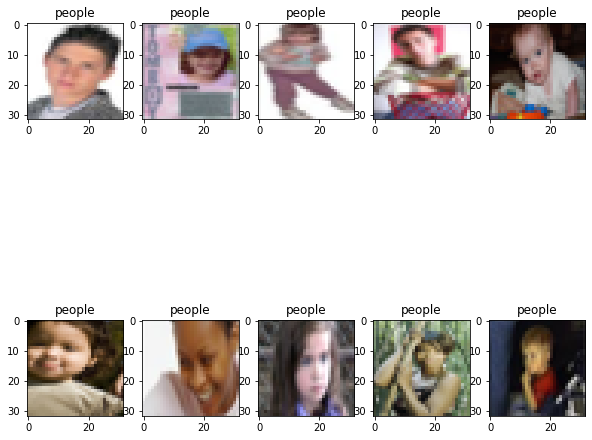

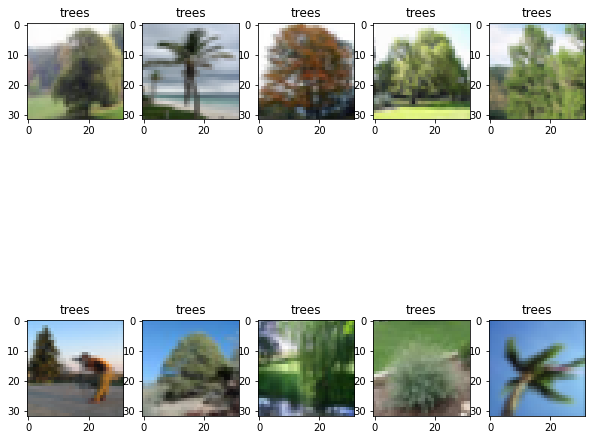

In [203]:
# Visualize the images in `Train_data_tree_people` to double check if we pull the correct images and
# if they align with the labels `Train_coarse`

plt.subplots(2,5, figsize=(10,10))


for n in range(10):
    index_people = random.choice(Train_coarse_tree_people.index[Train_coarse_tree_people['coarse'] == 0])
    image = Train_data_tree_people[index_people]
    plt.subplot(2,5,n+1) 
    plt.title('people')
    plt.imshow(image.astype('uint8'))
    
plt.subplots(2,5, figsize=(10,10))    

for n in range(10):
    index_trees = random.choice(Train_coarse_tree_people.index[Train_coarse_tree_people['coarse'] == 1])
    image = Train_data_tree_people[index_trees]
    plt.subplot(2,5,n+1) 
    plt.title('trees')
    plt.imshow(image.astype('uint8'))



Everything looks good, so we will do the same on the test dataset.

In [204]:
# Need to find all indices that matches to superclass tree (17) and people (14)

# create list to store all indices of tree/people
tree_people_index = []

# create df to store modified Train_coarse
Test_coarse_tree_people = pd.DataFrame(columns=['coarse'], index=range(1000))
counter = 0 

# loop through Train_coarse to find these indices:
for i in range(len(Test_coarse)):
    if ((Test_coarse.iloc[i, 0] == 17) | (Test_coarse.iloc[i, 0] == 14)):
        tree_people_index.append(i)
        Test_coarse_tree_people.loc[counter].coarse = Test_coarse.iloc[i, 0]
        counter += 1
Test_coarse_tree_people = Test_coarse_tree_people.astype(int)
# Print to check results, we should have 1000 images in total 
print('# of images:', len(tree_people_index))
Test_coarse_tree_people.head()

# of images: 1000


coarse
0      17
1      14
2      17
3      14
4      17

In [205]:
# change class to 0 and 1 instead of 14 and 17
Test_coarse_tree_people.loc[Test_coarse_tree_people['coarse']==14] = 0
Test_coarse_tree_people.loc[Test_coarse_tree_people['coarse']==17] = 1
Test_coarse_tree_people

coarse
0         1
1         0
2         1
3         0
4         1
..      ...
995       1
996       1
997       0
998       1
999       1

[1000 rows x 1 columns]

In [206]:
# Using the indices to extract the image data

# Create an empty array to store trees/people
Test_data_tree_people = np.zeros((1000, 32, 32, 3))
counter =0

# loop through Train_data to grab trees/people images data
for i in tree_people_index:
    Test_data_tree_people[counter] = Test_data[i] 
    counter += 1  

# Check, should have shape of 5000,32,32,3 
Test_data_tree_people.shape

(1000, 32, 32, 3)

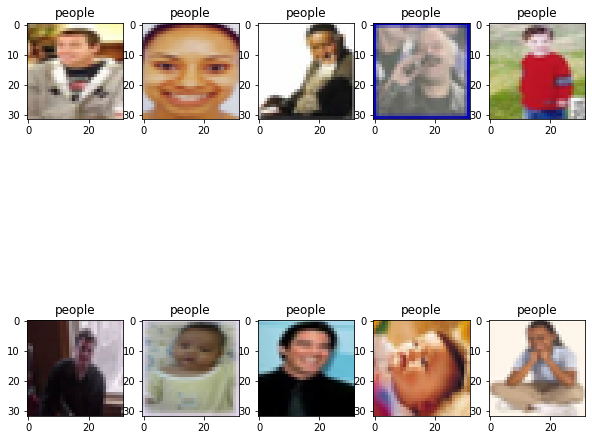

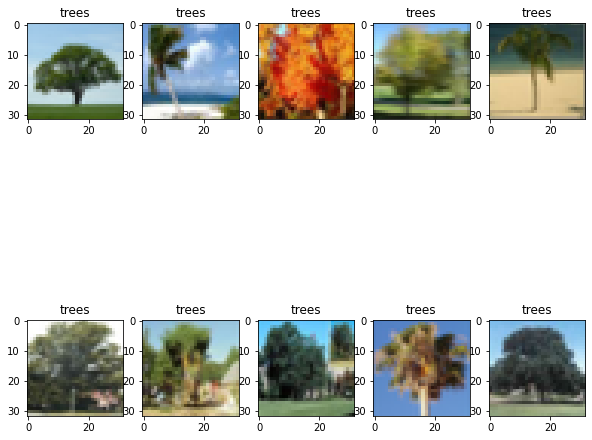

In [207]:
# Visualize the images in `Test_data_tree_people` to double check if we pull the correct images and
# if they align with the labels `Test_coarse`

plt.subplots(2,5, figsize=(10,10))


for n in range(10):
    index_people = random.choice(Test_coarse_tree_people.index[Test_coarse_tree_people['coarse'] == 0])
    image = Test_data_tree_people[index_people]
    plt.subplot(2,5,n+1) 
    plt.title('people')
    plt.imshow(image.astype('uint8'))
    
plt.subplots(2,5, figsize=(10,10))    

for n in range(10):
    index_trees = random.choice(Test_coarse_tree_people.index[Test_coarse_tree_people['coarse'] == 1])
    image = Test_data_tree_people[index_trees]
    plt.subplot(2,5,n+1) 
    plt.title('trees')
    plt.imshow(image.astype('uint8'))



In [208]:
# Set our X_train, y_train and X_test, y_test

X_train = Train_data_tree_people
y_train = Train_coarse_tree_people.astype(str).astype(int) #set coarse/superclass as our classification target

X_test = Test_data_tree_people
y_test = Test_coarse_tree_people.astype(str).astype(int)

# Create training image data generator
train_datagen = ImageDataGenerator(validation_split = 0.2)

 
train_generator=train_datagen.flow(X_train, y_train, shuffle=False, batch_size=128, subset='training')
validation_generator = train_datagen.flow(X_train, y_train, shuffle=False, batch_size=128, subset='validation')
 
ES = EarlyStopping(monitor='val_loss', patience=5, mode='auto', min_delta=0.0001, verbose=1)

We expect 500 images per class, so the classes seem balance for the most part.

In [209]:
    #=========================================================================================
    # CONFUSION MATRIX - **changing dimension of labels**
    #=========================================================================================
   
    from sklearn.metrics import confusion_matrix
    def confusion(model):
        # Calculate the predicted labels for each test image.
        predict_probas = model.predict(X_test)
        y_predict = np.argmax(predict_probas, axis=1)

        # Create the confusion matrix using sklearn 
        conf_mat = confusion_matrix(y_test, y_predict)

        # Since we have many images, it is helpful to show our 
        # results as fractions of the total number of images 
        # for each class.
        normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

        normalized_conf_mat = pd.DataFrame(normalized_conf_mat, columns=['people', 'tree'])

        plt.figure(figsize = (5,5))
        sns.heatmap(normalized_conf_mat,
                    annot=True,
                    cbar=False,
                    cmap="rocket_r",
                    linewidths=1
                   )
        plt.title('Confusion Matrix',size = 10,y=1.01)
        plt.xlabel("Predicted Label", size = 2)
        plt.ylabel("True Label", size = 2)
        plt.show()
        
ES = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', min_delta=0.0001, verbose=1)


##### ACNN 1 - Model 4

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 13, 13, 256)       295168    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 4, 4, 512)       

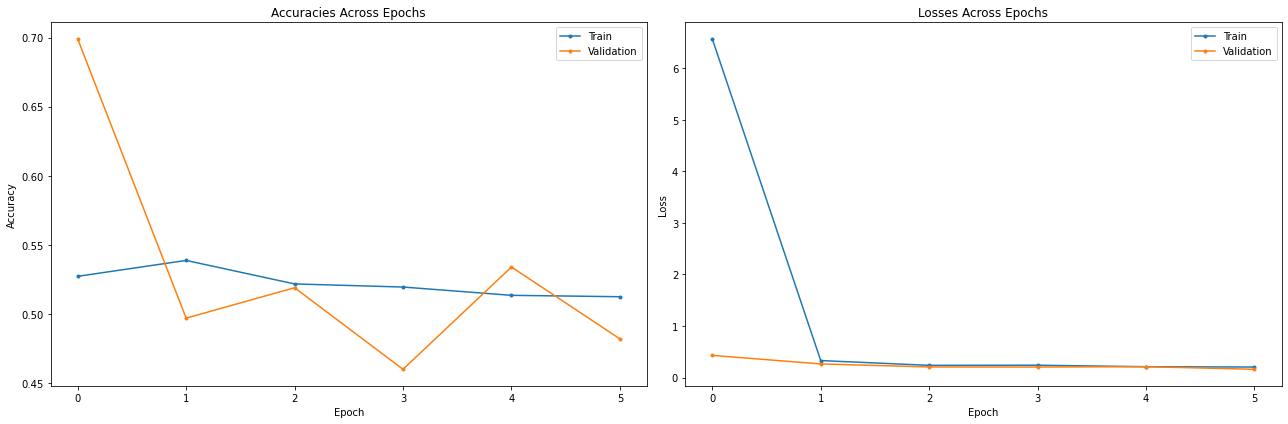

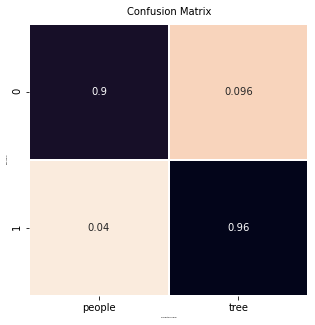

In [210]:

ACNN_model4i = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
ACNN_model4i.add(Conv2D(128, kernel_size=(3, 3), activation = 'relu', input_shape = (32,32,3)))
ACNN_model4i.add(MaxPooling2D(pool_size=(2, 2)))
ACNN_model4i.add(Dropout(0.1))

ACNN_model4i.add(Conv2D(256, kernel_size=(3, 3), activation = 'relu'))
ACNN_model4i.add(MaxPooling2D(pool_size=(2, 2)))
ACNN_model4i.add(Dropout(0.2))

ACNN_model4i.add(Conv2D(512, kernel_size=(3, 3), activation = 'relu'))
ACNN_model4i.add(MaxPooling2D(pool_size=(2, 2)))
ACNN_model4i.add(Dropout(0.4))

# Flatten the output of our convolutional layers
ACNN_model4i.add(Flatten())

# Add dense layers
ACNN_model4i.add(Dense(512, activation= 'relu'))
ACNN_model4i.add(Dense(256, activation= 'relu'))
ACNN_model4i.add(Dense(128, activation= 'relu'))
ACNN_model4i.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Print out a summary of the network
ACNN_model4i.summary()

# Compile the model with the desired loss function, optimizer, and metric(s) to track
ACNN_model4i.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
ACNN4i = ACNN_model4i.fit(train_generator,
                          epochs = 50,
                          verbose = 1,
                          validation_data = validation_generator,
                           callbacks=ES)



test_loss_score(ACNN_model4i)
accuracy_loss_plots(ACNN4i)
confusion(ACNN_model4i)

save_format='h5'
ACNN_model4i.save('CNNmodels/ACNN_model4i.h5')

As you can see from the above results, the accuracy scores still do not improve after each epoch despite the loss continues to decline. Moreover, the confusion matrix showed there is very high accuracy in predicting the correct classes! Ultimately, we just want to have a model that can predict the correct class, so these models are still useful despite the strangely low accuracy indicated by TensorFlow.

## Grayscale - Superclass

Here we will take a look how the model accuracy will differ if we feed in grayscale images rather than coloured.

### Basic Models - Logistic Regression

We will try out the basic model and see how the accuracy scores are.

In [62]:
# Set our X_train, y_train and X_test, y_test

X_train_flat = Train_flat_data_gray
y_train = np.array(train[b'coarse_labels']) #set coarse/superclass as our classification target

X_test_flat = Test_flat_data_gray
y_test = np.array(test[b'coarse_labels'])

In [63]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=1, n_jobs=-1)
LR.fit(X_train_flat, y_train)
print('Train score: ', LR.score(X_train_flat, y_train))
print('Test score: ', LR.score(X_test_flat, y_test))

Train score:  0.19532
Test score:  0.1635


##### GCNN 1 - Model 2

In [73]:
# Set our X_train, y_train and X_test, y_test

X_train = Train_data_gray
y_train = Train_coarse #set coarse/superclass as our classification target

X_test = Test_data_gray
y_test = Test_coarse

In [74]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 1), (50000, 1), (10000, 32, 32, 1), (10000, 1))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 4, 4, 256)       

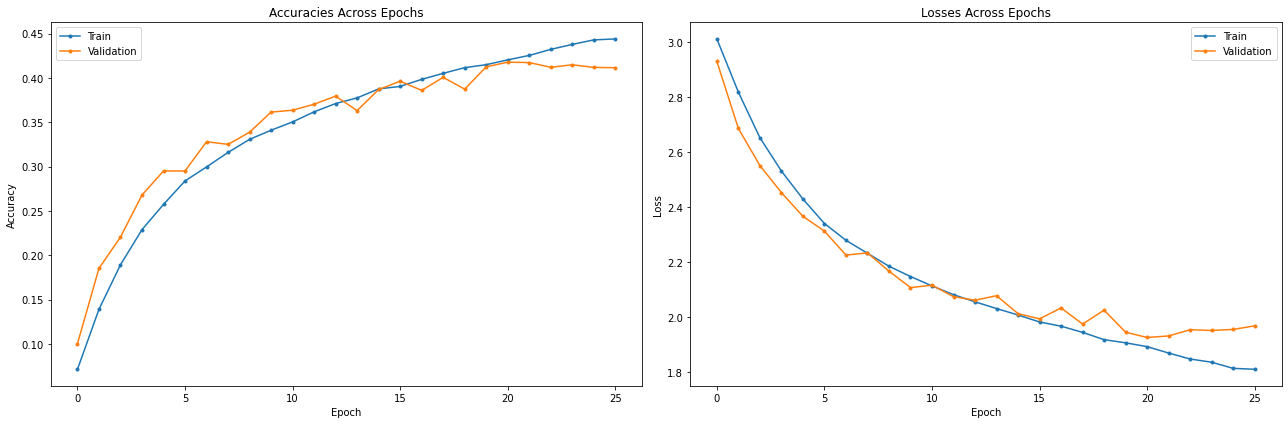

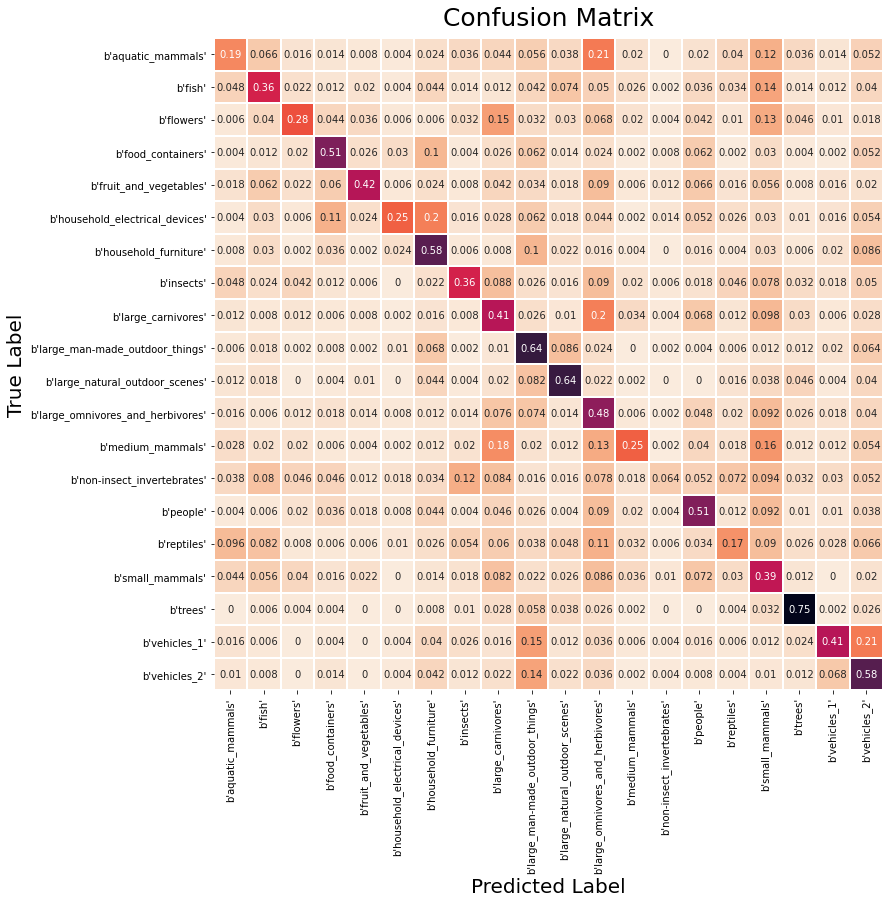

In [75]:
GCNN_model2 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
GCNN_model2.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = X_train[0].shape))
GCNN_model2.add(MaxPooling2D(pool_size=(2, 2)))
GCNN_model2.add(Dropout(0.1))

GCNN_model2.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu'))
GCNN_model2.add(MaxPooling2D(pool_size=(2, 2)))
GCNN_model2.add(Dropout(0.2))

GCNN_model2.add(Conv2D(256, kernel_size=(3, 3), activation = 'relu'))
GCNN_model2.add(MaxPooling2D(pool_size=(2, 2)))
GCNN_model2.add(Dropout(0.4))

# Flatten the output of our convolutional layers
GCNN_model2.add(Flatten())

# Add dense layers
GCNN_model2.add(Dense(256, activation= 'relu'))
GCNN_model2.add(Dense(64, activation= 'relu'))
GCNN_model2.add(Dense(32, activation= 'relu'))
GCNN_model2.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Print out a summary of the network
GCNN_model2.summary()

# Compile the model with the desired loss function, optimizer, and metric(s) to track
GCNN_model2.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
GCNN2 = GCNN_model2.fit(X_train, y_train,
                          epochs = 50,
                          verbose = 1,
                          validation_split=0.2,
                            callbacks = ES)



test_loss_score(GCNN_model2)
accuracy_loss_plots(GCNN2)
confusion(GCNN_model2)

save_format='h5'
GCNN_model2.save('CNNmodels/GCNN_model2.h5')

##### GCNN 1 - Model 4

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 30, 30, 128)       1280      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 13, 13, 256)       295168    
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 4, 4, 512)       

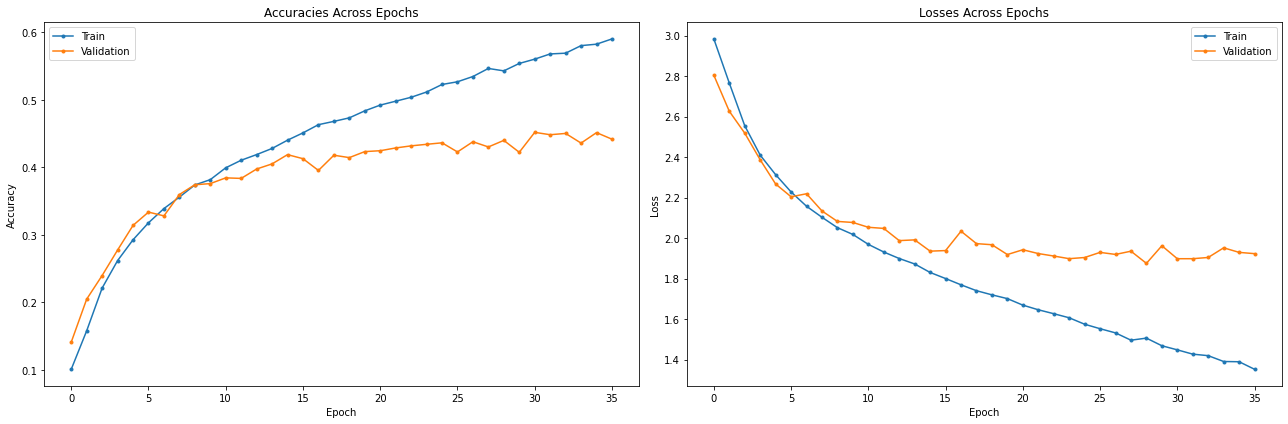

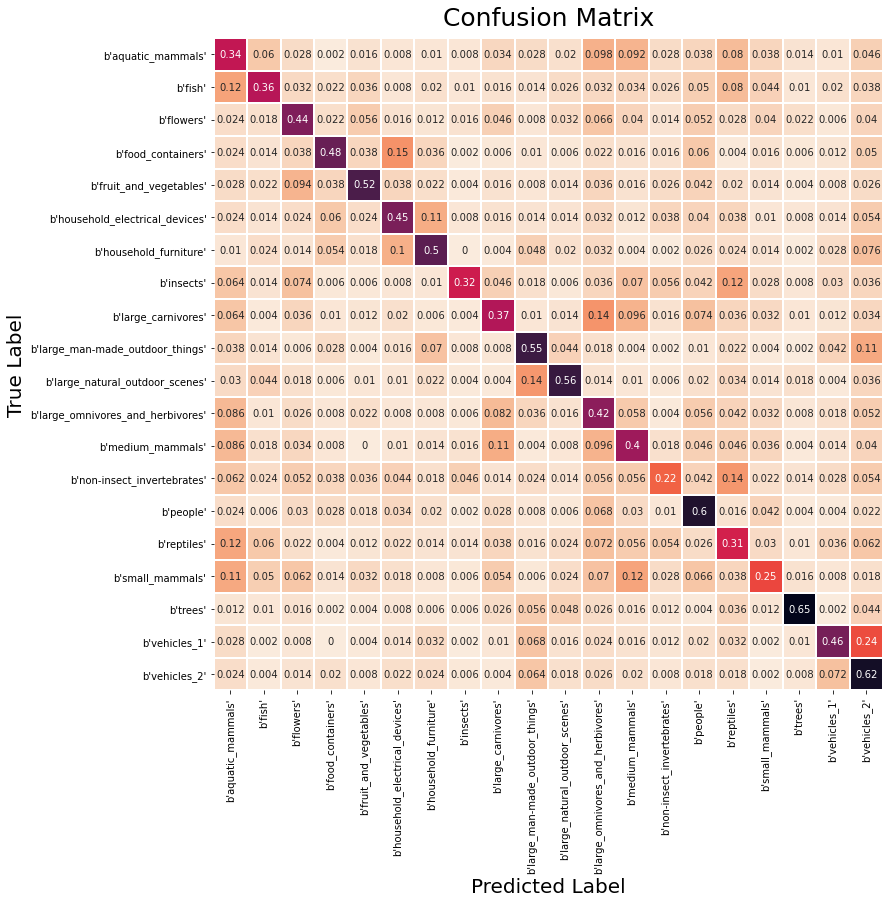

In [77]:

GCNN_model4 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
GCNN_model4.add(Conv2D(128, kernel_size=(3, 3), activation = 'relu',input_shape = X_train[0].shape))
GCNN_model4.add(MaxPooling2D(pool_size=(2, 2)))
GCNN_model4.add(Dropout(0.1))

GCNN_model4.add(Conv2D(256, kernel_size=(3, 3), activation = 'relu'))
GCNN_model4.add(MaxPooling2D(pool_size=(2, 2)))
GCNN_model4.add(Dropout(0.2))

GCNN_model4.add(Conv2D(512, kernel_size=(3, 3), activation = 'relu'))
GCNN_model4.add(MaxPooling2D(pool_size=(2, 2)))
GCNN_model4.add(Dropout(0.4))

# Flatten the output of our convolutional layers
GCNN_model4.add(Flatten())

# Add dense layers
GCNN_model4.add(Dense(512, activation= 'relu'))
GCNN_model4.add(Dense(256, activation= 'relu'))
GCNN_model4.add(Dense(128, activation= 'relu'))
GCNN_model4.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Print out a summary of the network
GCNN_model4.summary()

# Compile the model with the desired loss function, optimizer, and metric(s) to track
GCNN_model4.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
GCNN4 = GCNN_model4.fit(X_train, y_train,
                          epochs = 50,
                          verbose = 1,
                          validation_split=0.2,
                            callbacks = ES)


test_loss_score(GCNN_model4)
accuracy_loss_plots(GCNN4)
confusion(GCNN_model4)

save_format='h5'
GCNN_model4.save('CNNmodels/GCNN_model4.h5')

Both models show a 13-14% lower accuracy on the test set with grayscale images. This is possibly because the colour offers additional clues for the model to learn the different superclasses. 

A few interesting notes:
-  Flowers category has highest accuracy (80%) when classifying by colour image, but the accuracy is only 44% with grayscale image. From EDA, we can see that flowers images have vibrant colours, and possibly colour offers much of the visual cues when it comes to predicting this category!
- Tress still maintained its accuracy. It is possible that trees have very similar shapes with the foliage and trunk, so colour is not critical in identifying trees.
- Similarly, people category also maintained its accuracy. It is possible the facial features and limbs/body are more useful than colour when it comes to predicting this category!

# Classification Models - Class

From the above where we trained on augmented images of superclasses, Model 4 seemed to have yield the highest accuracy score according to the confusion matrix, therefore, we will apply Model 4 to the augmented classes and see how that performs!

## Color - Class

### Basic Models - Logistic Regression

First of all, we will try out the basic model and see how the accuracy scores are.

In [ ]:
# Set our X_train, y_train and X_test, y_test

X_train_flat = Train_flat_data
y_train = np.array(train[b'fine_labels']) #set coarse/superclass as our classification target

X_test_flat = Test_flat_data
y_test = np.array(test[b'fine_labels'])

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=1, n_jobs=-1)
LR.fit(X_train_flat, y_train)
print('Train score: ', LR.score(X_train_flat, y_train))
print('Test score: ', LR.score(X_test_flat, y_test))

### CNN Models

##### Set up train and test sets

In [27]:
# Set our X_train, y_train and X_test, y_test

X_train = Train_data
y_train = Train_fine #set fine/class as our classification target

X_test = Test_data
y_test = Test_fine

# Create training image data generator
train_datagen = ImageDataGenerator(rotation_range = 30,
                                   horizontal_flip=True,
                                   validation_split=0.2)

 
train_generator=train_datagen.flow(X_train, y_train, shuffle=False, batch_size=128, subset='training')
validation_generator = train_datagen.flow(X_train, y_train, shuffle=False, batch_size=128, subset='validation')
 
ES = EarlyStopping(monitor='val_loss', patience=5, mode='auto', min_delta=0.0001, verbose=1)

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

##### ACNN 1C - Model 4

In [54]:
ACNN_model4_class = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
ACNN_model4_class.add(Conv2D(128, kernel_size=(3, 3), activation = 'relu', input_shape = (32,32,3)))
ACNN_model4_class.add(MaxPooling2D(pool_size=(2, 2)))
ACNN_model4_class.add(Dropout(0.1))

ACNN_model4_class.add(Conv2D(256, kernel_size=(3, 3), activation = 'relu'))
ACNN_model4_class.add(MaxPooling2D(pool_size=(2, 2)))
ACNN_model4_class.add(Dropout(0.2))

ACNN_model4_class.add(Conv2D(512, kernel_size=(3, 3), activation = 'relu'))
ACNN_model4_class.add(MaxPooling2D(pool_size=(2, 2)))
ACNN_model4_class.add(Dropout(0.4))

# Flatten the output of our convolutional layers
ACNN_model4_class.add(Flatten())

# Add dense layers
ACNN_model4_class.add(Dense(512, activation= 'relu'))
ACNN_model4_class.add(Dense(256, activation= 'relu'))
ACNN_model4_class.add(Dense(128, activation= 'relu'))
ACNN_model4_class.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Print out a summary of the network
ACNN_model4_class.summary()

# Compile the model with the desired loss function, optimizer, and metric(s) to track
ACNN_model4_class.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

# Fit the model on the training data, defining desired batch_size & number of epochs,
# running validation after each batch
ACNN4_class = ACNN_model4_class.fit(train_generator,
                          epochs = 100,
                          verbose = 1,
                          validation_data = validation_generator,
                            callbacks = ES)


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 256)       295168    
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 512)        

Test loss: 2.4348912239074707
Test accuracy: 0.011800000444054604

 



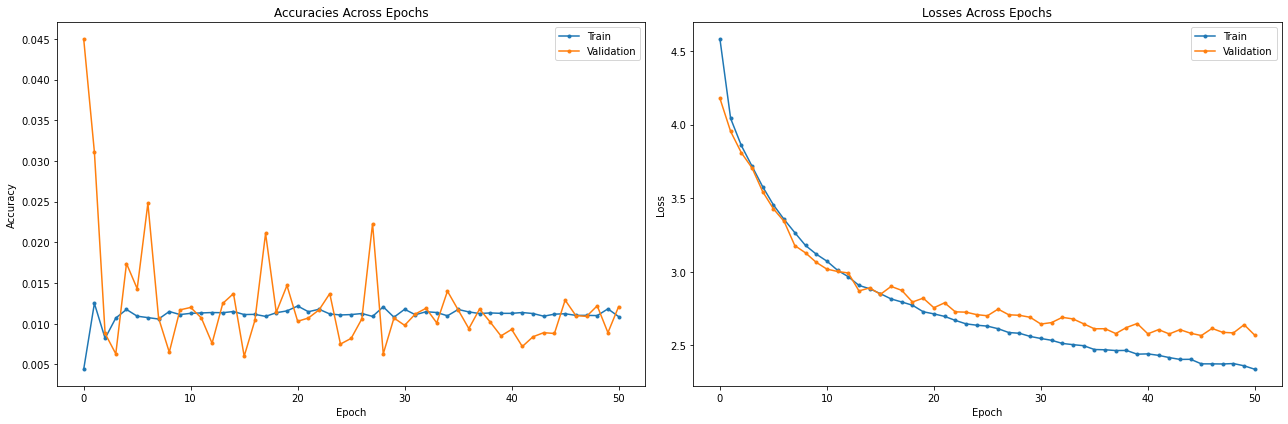

In [107]:
test_loss_score(ACNN_model4_class)
accuracy_loss_plots(ACNN4_class)
save_format='h5'
ACNN_model4_class.save('CNNmodels/ACNN_model4_class.h5')

The accuracy score on the test set is 1%, which is really bad given that there are 100 classes in total and there is 1 in 100 chances of predicting the correct class. The accuracy/loss plot is similar to what we have seen previously. To check what the real accuracy score, we can review the classification report.

In [104]:
from sklearn.metrics import classification_report

# get the classification report and turn into dataframe
predict_probas = ACNN_model4_class.predict(X_test)
y_predict = np.argmax(predict_probas, axis=1)
report = pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).T

# insert class label into the classification report
report['class'] = list(CL) + ['accuracy', 'macro avg', 'weighted avg']

# rearrange the columns
report = report[['class', 'precision', 'recall', 'f1-score', 'support']]

# reset 'class' column as index
report.set_index('class', drop=True, inplace=True)

# sort by f1-score
report.sort_values('f1-score', inplace=True, ascending=False)

In [105]:
pd.set_option('display.max_rows',103)
report

precision  recall  f1-score     support
class                                                    
b'sunflower'       0.764706  0.7800  0.772277    100.0000
b'plain'           0.717172  0.7100  0.713568    100.0000
b'road'            0.693069  0.7000  0.696517    100.0000
b'skyscraper'      0.702128  0.6600  0.680412    100.0000
b'skunk'           0.595420  0.7800  0.675325    100.0000
b'apple'           0.593220  0.7000  0.642202    100.0000
b'castle'          0.700000  0.5600  0.622222    100.0000
b'lawn_mower'      0.714286  0.5500  0.621469    100.0000
b'orange'          0.607843  0.6200  0.613861    100.0000
b'cockroach'       0.563025  0.6700  0.611872    100.0000
b'palm_tree'       0.525547  0.7200  0.607595    100.0000
b'chair'           0.480769  0.7500  0.585938    100.0000
b'oak_tree'        0.496454  0.7000  0.580913    100.0000
b'cloud'           0.492537  0.6600  0.564103    100.0000
b'wardrobe'        0.445783  0.7400  0.556391    100.0000
b'rocket'          0.517241  0.6000  0.555556    100.0000
b'sea'             0.532110  0.5800  0.555024    100.0000
b'chimpanzee'      0.486957  0.5600  0.520930    100.0000
b'orchid'          0.616438  0.4500  0.520231    100.0000
b'cup'             0.602740  0.4400  0.508671    100.0000
b'motorcycle'      0.394444  0.7100  0.507143    100.0000
b'poppy'           0.528090  0.4700  0.497354    100.0000
b'trout'           0.417808  0.6100  0.495935    100.0000
b'keyboard'        0.385542  0.6400  0.481203    100.0000
b'plate'           0.517647  0.4400  0.475676    100.0000
b'pickup_truck'    0.479592  0.4700  0.474747    100.0000
b'maple_tree'      0.489362  0.4600  0.474227    100.0000
b'aquarium_fish'   0.427419  0.5300  0.473214    100.0000
b'whale'           0.419355  0.5200  0.464286    100.0000
b'telephone'       0.403226  0.5000  0.446429    100.0000
b'bottle'          0.493827  0.4000  0.441989    100.0000
b'hamster'         0.452632  0.4300  0.441026    100.0000
b'dinosaur'        0.451613  0.4200  0.435233    100.0000
b'worm'            0.420561  0.4500  0.434783    100.0000
b'tank'            0.407080  0.4600  0.431925    100.0000
b'bee'             0.437500  0.4200  0.428571    100.0000
b'beetle'          0.500000  0.3600  0.418605    100.0000
b'pear'            0.514706  0.3500  0.416667    100.0000
b'rose'            0.507246  0.3500  0.414201    100.0000
b'bridge'          0.377193  0.4300  0.401869    100.0000
b'spider'          0.396040  0.4000  0.398010    100.0000
accuracy           0.393600  0.3936  0.393600      0.3936
b'television'      0.386139  0.3900  0.388060    100.0000
b'tractor'         0.395833  0.3800  0.387755    100.0000
weighted avg       0.397958  0.3936  0.384300  10000.0000
macro avg          0.397958  0.3936  0.384300  10000.0000
b'mountain'        0.547170  0.2900  0.379085    100.0000
b'sweet_pepper'    0.406977  0.3500  0.376344    100.0000
b'bicycle'         0.350877  0.4000  0.373832    100.0000
b'lion'            0.297619  0.5000  0.373134    100.0000
b'clock'           0.428571  0.3300  0.372881    100.0000
b'bus'             0.308725  0.4600  0.369478    100.0000
b'tiger'           0.285714  0.5200  0.368794    100.0000
b'porcupine'       0.518519  0.2800  0.363636    100.0000
b'elephant'        0.307692  0.4400  0.362140    100.0000
b'wolf'            0.255605  0.5700  0.352941    100.0000
b'lamp'            0.308271  0.4100  0.351931    100.0000
b'shark'           0.316667  0.3800  0.345455    100.0000
b'flatfish'        0.311475  0.3800  0.342342    100.0000
b'raccoon'         0.324324  0.3600  0.341232    100.0000
b'caterpillar'     0.394737  0.3000  0.340909    100.0000
b'baby'            0.336634  0.3400  0.338308    100.0000
b'dolphin'         0.308333  0.3700  0.336364    100.0000
b'couch'           0.361446  0.3000  0.327869    100.0000
b'ray'             0.415385  0.2700  0.327273    100.0000
b'train'           0.352941  0.3000  0.324324    100.0000
b'table'           0.362500  0.2900  0.322222    100.0000
b'streetcar'    

Classification report shows that the accuracy score is actually around 39%. Approximately 30-40 classes was predicted correctly with an accuracy above 39%. To get a better sense of what the model is confused about, we will visualize these incorrectly predicted images.

In [172]:
import math

y_test_label = y_test['fine']
incorrect_photos = y_test_label != y_predict
incorrect_indices = []


# loop through incorrect_photos to find these indices of true (incorrect prediction):
for i in range(len(incorrect_photos)):
    if incorrect_photos[i] == True:
        incorrect_indices.append(i) 

num_images = np.count_nonzero(incorrect_photos)
num_images

6064

In [175]:
#Check to make sure it picked up everything (should equal to 6064)
len(incorrect_indices)

6064

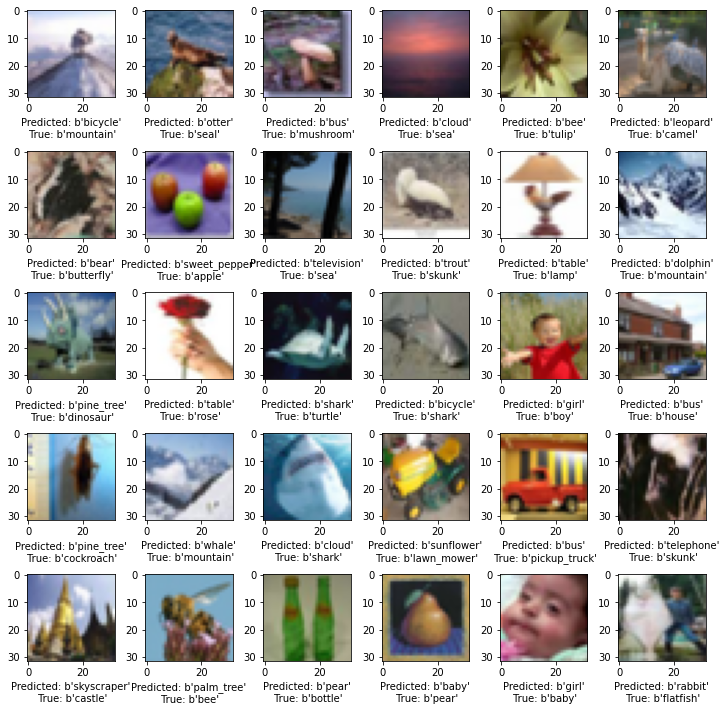

In [197]:
# Print the first 30 incorrect images
columns = 5
rows = 6
class_labels = list(CL)

plt.subplots(5,6, figsize=(10,10))

axes = axes.flatten()

for i in range(30):
    image = X_test[incorrect_indices][i]
    plt.subplot(5,6, i+1)
    plt.imshow(image)
    
    # Get predicted label
    predicted_label = class_labels[y_predict[incorrect_indices[i]]]
    
    # Get actual label
    true_label = class_labels[y_test_label[incorrect_indices[i]]]
    
    # Set the title of the subplot
    plt.xlabel(f"Predicted: {predicted_label}\n True: {true_label}")

plt.tight_layout()


Some of the images are quite confusing, especially when it comes to `boy`, `girl` and `baby`. Even with human eyes, I might not have guessed it correctly.